In [1]:
conda install -c conda-forge pymc rasterio geopandas shapely

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/wildfire

  added / updated specs:
    - geopandas
    - pymc
    - rasterio
    - shapely


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blosc-1.21.5               |       h9c252e8_1          32 KB  conda-forge
    cfitsio-3.470              |       ha83d327_7         1.2 MB  conda-forge
    expat-2.7.0                |       h286801f_0         124 KB  conda-forge
    gdk-pixbuf-2.42.10         |       h969f7ef_2         579 KB
    geos-3.10.6                |       h303483a_0         1.1 MB  conda-forge
    geotiff-1.7.0              |       hcec61be_4         126 KB
    kealib-1.5.0               |       h3444380_2         144 KB
    libcxx-20.1.4              |       ha82da77_1         554 KB  conda-forge
    libexpat-2.7.0            

In [3]:
!clang --version

Apple clang version 16.0.0 (clang-1600.0.26.6)
Target: arm64-apple-darwin24.3.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin


In [2]:
import warnings

from itertools import product



import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib import MatplotlibDeprecationWarning
from numpy.random import default_rng

warnings.filterwarnings(action="ignore", category=MatplotlibDeprecationWarning)

In [3]:
import os
import rasterio
from glob import glob
import geopandas as gpd
from rasterio.warp import transform_bounds
from shapely.geometry import Polygon
from pyproj import Transformer

In [4]:
# copy the layour tifs from a folder to a folder called sim2real_layout
import shutil

# Create the destination folder if it doesn't exist
os.makedirs("sim2real_layout", exist_ok=True)
for folder in os.listdir("WideDataset/"):
    # skip .DS_Store
    if folder == ".DS_Store":
        continue
    # open the "Fuel_Map" subfolder and copy the Canopy_Base_Height.tif file
    shutil.copy(f"WideDataset/{folder}/Vegetation_Map/Existing_Vegetation_Cover.tif", f"sim2real_layout/{folder}_Existing_Vegetation_Cover.tif")

In [ ]:
def decimal_to_dms(decimal):
    degrees = int(decimal)
    remaining = abs(decimal) - abs(degrees)
    minutes = int(remaining * 60)
    seconds = (remaining * 60 - minutes) * 60
    return degrees, minutes, seconds

def print_decimal_to_dms(decimal_long, decimal_lat, extra_text = ''):
    degrees_lat = int(decimal_lat)
    remaining_lat = abs(decimal_lat) - abs(degrees_lat)
    minutes_lat = int(remaining_lat * 60)
    seconds_lat = (remaining_lat * 60 - minutes_lat) * 60
    degrees_long = int(decimal_long)
    remaining_long = abs(decimal_long) - abs(degrees_long)
    minutes_long = int(remaining_long * 60)
    seconds_long = (remaining_long * 60 - minutes_long) * 60
    print(f"{extra_text}: {abs(degrees_lat)}° {minutes_lat}' {seconds_lat:.4f}\" {'S' if degrees_lat < 0 else 'N'} {abs(degrees_long)}° {minutes_long}' {seconds_long:.4f}\" {'W' if degrees_long < 0 else 'E'}")


# Path to the folder containing .tif files
folder_path = "sim2real_layout"

# Get a list of all .tif files in the folder
tif_files = glob(os.path.join(folder_path, "*.tif"))

layout_list = []
widths = []
heights = []
names = []

# Open each .tif file
for tif_file in tif_files:
    with rasterio.open(tif_file) as dataset:

        
        # get the file name without the path
        file_name = os.path.basename(tif_file)  # '0004_Elevation.tif'
        identifier = "_".join(file_name.split('_')[:2])

        # extract the resolution, check it is 30
        x_resolution = dataset.transform[0]
        y_resolution = -dataset.transform[4]
        assert x_resolution == y_resolution == 30, f"Resolution is not the same: {x_resolution} != {y_resolution}"

        # technique 1: using the bounds
        x_min = dataset.bounds[0]
        x_max = dataset.bounds[2]
        y_min = dataset.bounds[1]
        y_max = dataset.bounds[3]

        transformer = Transformer.from_crs(dataset.crs, "EPSG:4326", always_xy=True)
        lat_top_left, lon_top_left = transformer.transform(x_min, y_max)
        lat_top_right, lon_top_right = transformer.transform(x_max, y_max)
        lat_bottom_left, lon_bottom_left = transformer.transform(x_min, y_min)
        lat_bottom_right, lon_bottom_right = transformer.transform(x_max, y_min)


        # technique 2: using the pixel 0,0 : SAME AS 1 BUT OFF PY HALF A PIXEL
        # x_tl_pixel, y_tl_pixel = rasterio.transform.xy(dataset.transform, 0, 0)
        # x_bl_pixel, y_bl_pixel = rasterio.transform.xy(dataset.transform, dataset.height - 1, 0)
        # x_br_pixel, y_br_pixel = rasterio.transform.xy(dataset.transform, dataset.height - 1, dataset.width - 1)
        # x_tr_pixel, y_tr_pixel = rasterio.transform.xy(dataset.transform, 0, dataset.width - 1)

        # lat_tl_pixel, long_tl_pixel = transformer.transform(x_tl_pixel, y_tl_pixel)
        # lat_bl_pixel, long_bl_pixel = transformer.transform(x_bl_pixel, y_bl_pixel)
        # lat_br_pixel, long_br_pixel = transformer.transform(x_br_pixel, y_br_pixel)
        # lat_tr_pixel, long_tr_pixel = transformer.transform(x_tr_pixel, y_tr_pixel)


        # technique 3 : using the boundaries transformation : THIS IS REEAAAALY OFF. it's what we were using before. This somehow creates the lasrgest rectangle containing the raster (that is a rotated rectangle).
        # minx_boundary, miny_boundary, maxx_boundary, maxy_boundary = transform_bounds(dataset.crs, 'EPSG:4326', *dataset.bounds)

        # lat_tl_boundary, long_tl_boundary = minx_boundary, maxy_boundary
        # lat_bl_boundary, long_bl_boundary = minx_boundary, miny_boundary
        # lat_br_boundary, long_br_boundary = maxx_boundary, miny_boundary
        # lat_tr_boundary, long_tr_boundary = maxx_boundary, maxy_boundary

        # print the 3 different representations
        # if identifier == "0005_00725":
        #     print("top left:")
        #     print_decimal_to_dms(lat_top_left, lon_top_left)
        #     print_decimal_to_dms(lat_tl_pixel, long_tl_pixel)
        #     print_decimal_to_dms(lat_tl_boundary, long_tl_boundary)

        #     print("top right:")
        #     print_decimal_to_dms(lat_top_right, lon_top_right)
        #     print_decimal_to_dms(lat_tr_pixel, long_tr_pixel)
        #     print_decimal_to_dms(lat_tr_boundary, long_tr_boundary)

        #     print("bottom left:")
        #     print_decimal_to_dms(lat_bottom_left, lon_bottom_left)
        #     print_decimal_to_dms(lat_bl_pixel, long_bl_pixel)
        #     print_decimal_to_dms(lat_bl_boundary, long_bl_boundary)

        #     print("bottom right:")
        #     print_decimal_to_dms(lat_bottom_right, lon_bottom_right)
        #     print_decimal_to_dms(lat_br_pixel, long_br_pixel)
        #     print_decimal_to_dms(lat_br_boundary, long_br_boundary)        


        # Create the polygon using the transformed bounds
        polygon = Polygon((
            (lat_top_left, lon_top_left),
            (lat_top_right, lon_top_right),
            (lat_bottom_right, lon_bottom_right),
            (lat_bottom_left, lon_bottom_left),
            (lat_top_left, lon_top_left)  # close the polygon
        ))

        layout_list.append({
            'identifier': identifier,
            'height': dataset.height,
            'width': dataset.width,
            'geometry': polygon,
            'transform': dataset.transform
        })


        widths.append(dataset.width)
        heights.append(dataset.height)
        names.append(identifier)

sorted_indices = np.argsort(widths)
widths = np.array(widths)[sorted_indices]
heights = np.array(heights)[sorted_indices]
names = np.array(names)[sorted_indices]
filtered_layout_list = [layout_list[i] for i in sorted_indices]

n_small_layouts = len(widths[widths < 500])
n_medium_layouts = len(widths[(widths >= 500) & (widths < 1000)])
n_large_layouts = len(widths[widths >= 1000])

small_layouts = filtered_layout_list[:n_small_layouts]
medium_layouts = filtered_layout_list[n_small_layouts:n_small_layouts + n_medium_layouts]
large_layouts = filtered_layout_list[n_small_layouts + n_medium_layouts:]

# print width of smallest layout
print(min(widths))
# print id of smallest layout
print(names[np.argmin(widths)])











134
0101_02057


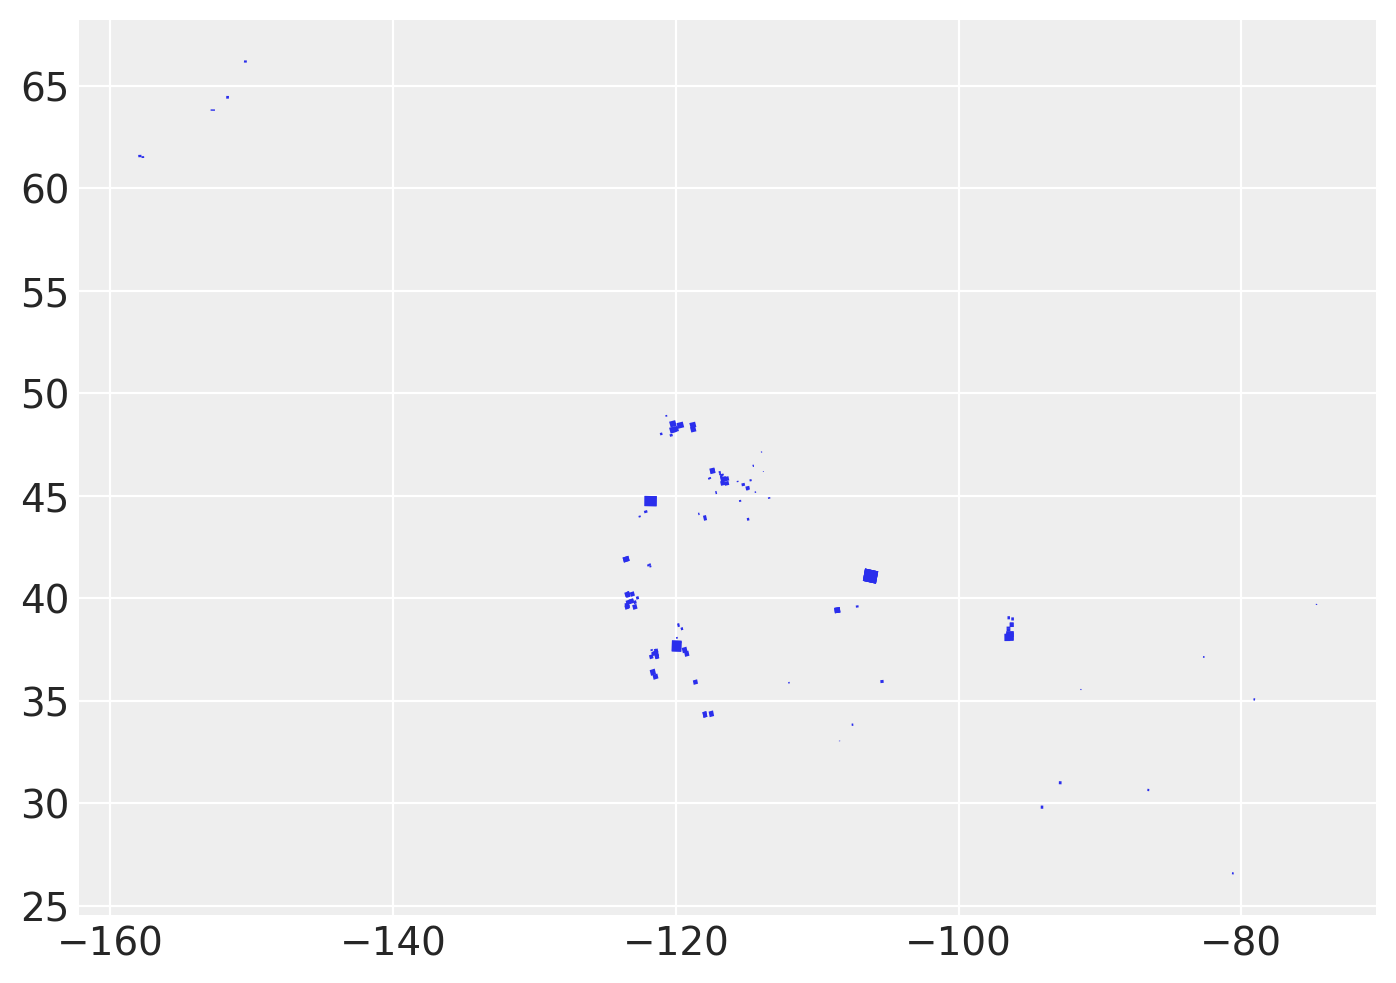

/var/folders/r5/_fbswsmn33dd9xcpxh63jhnm0000gp/T/ipykernel_51505/1070529709.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


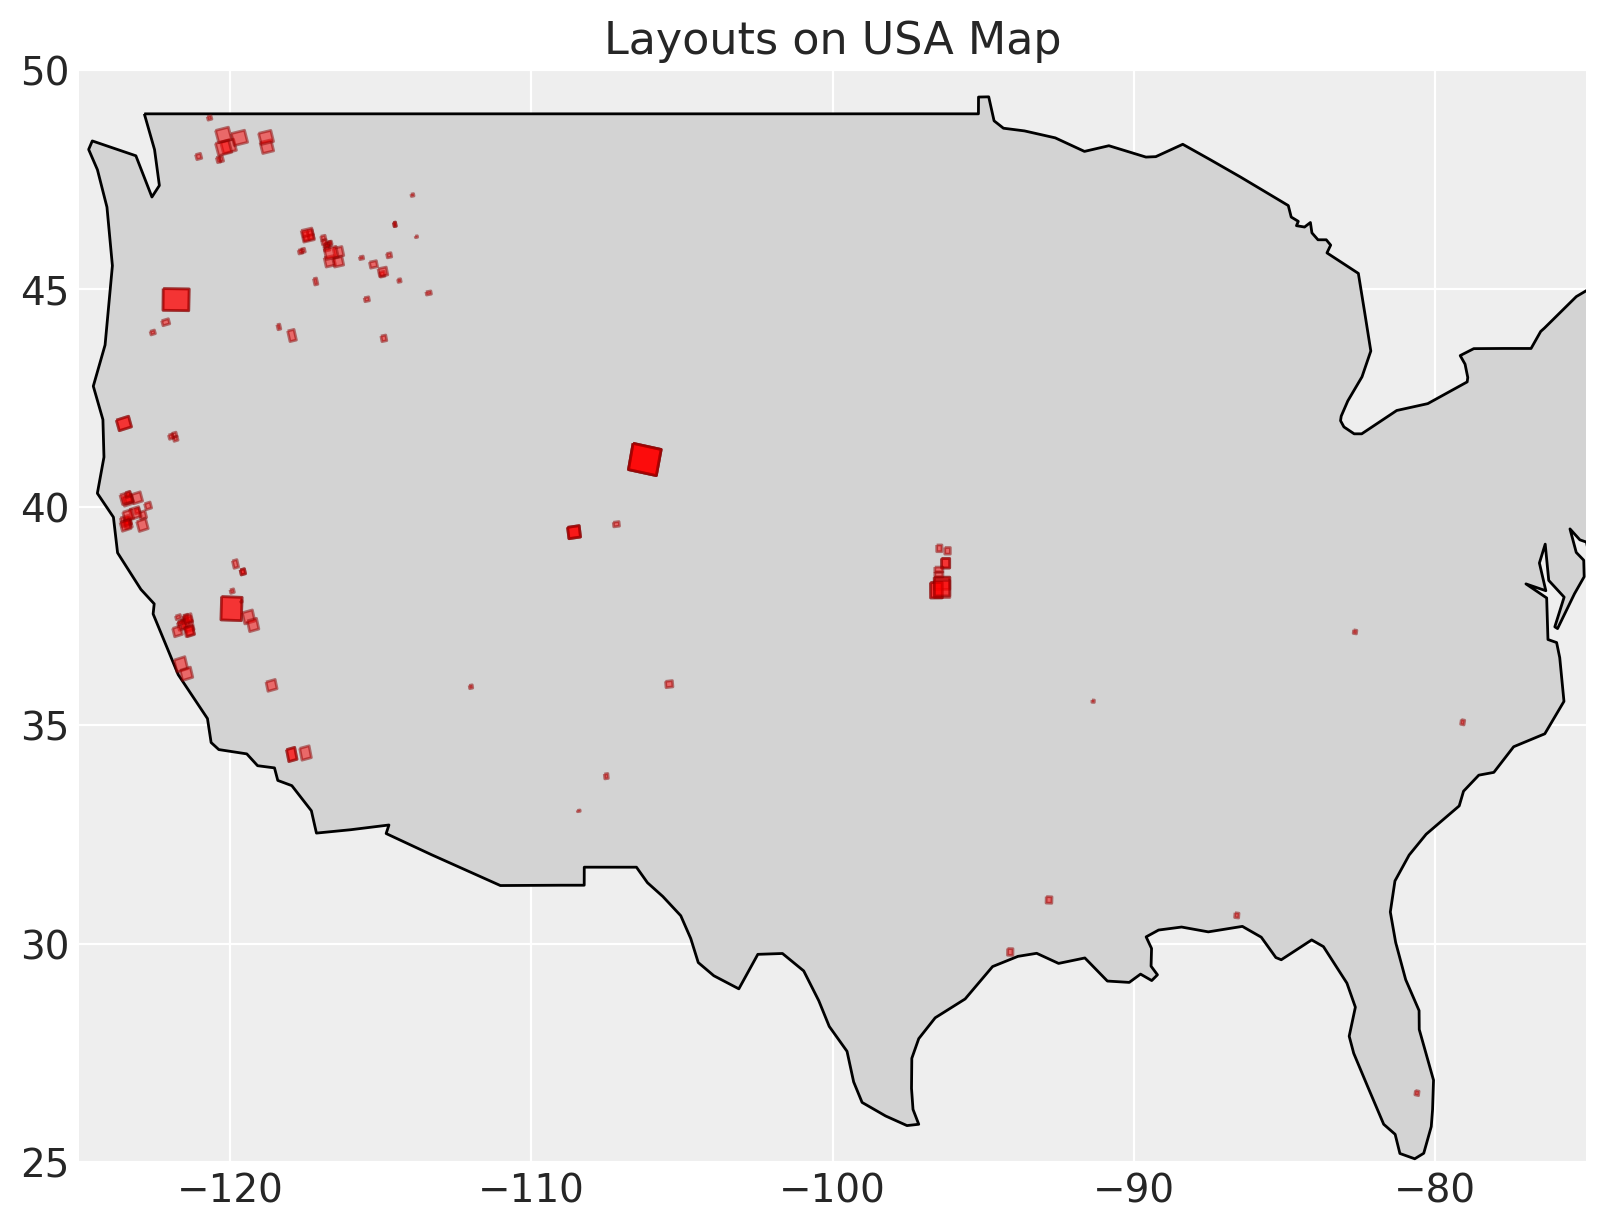

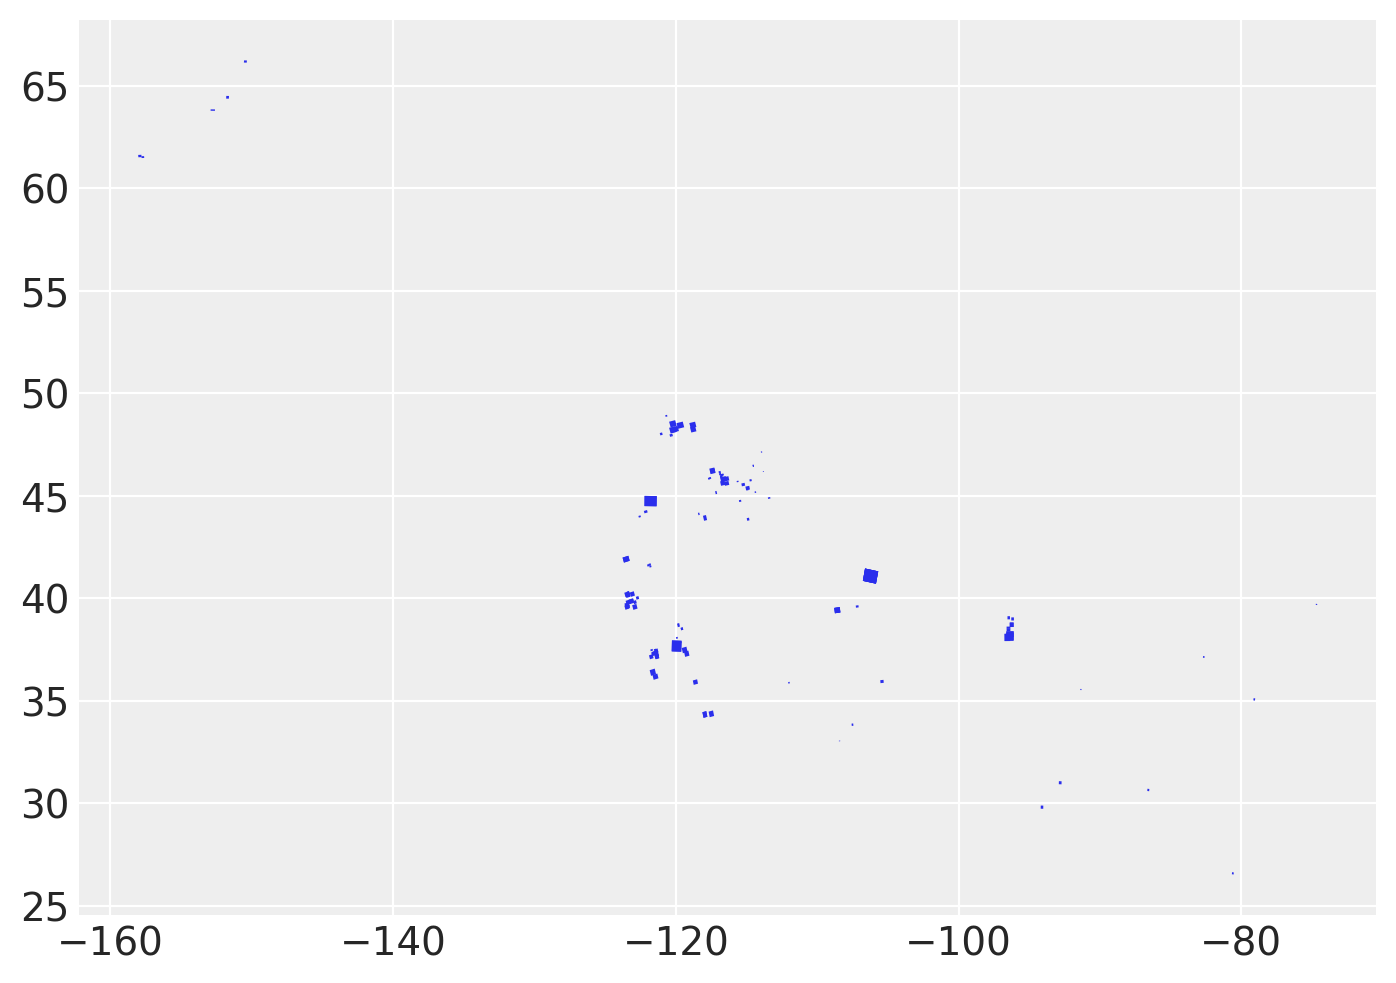

/var/folders/r5/_fbswsmn33dd9xcpxh63jhnm0000gp/T/ipykernel_51505/1070529709.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


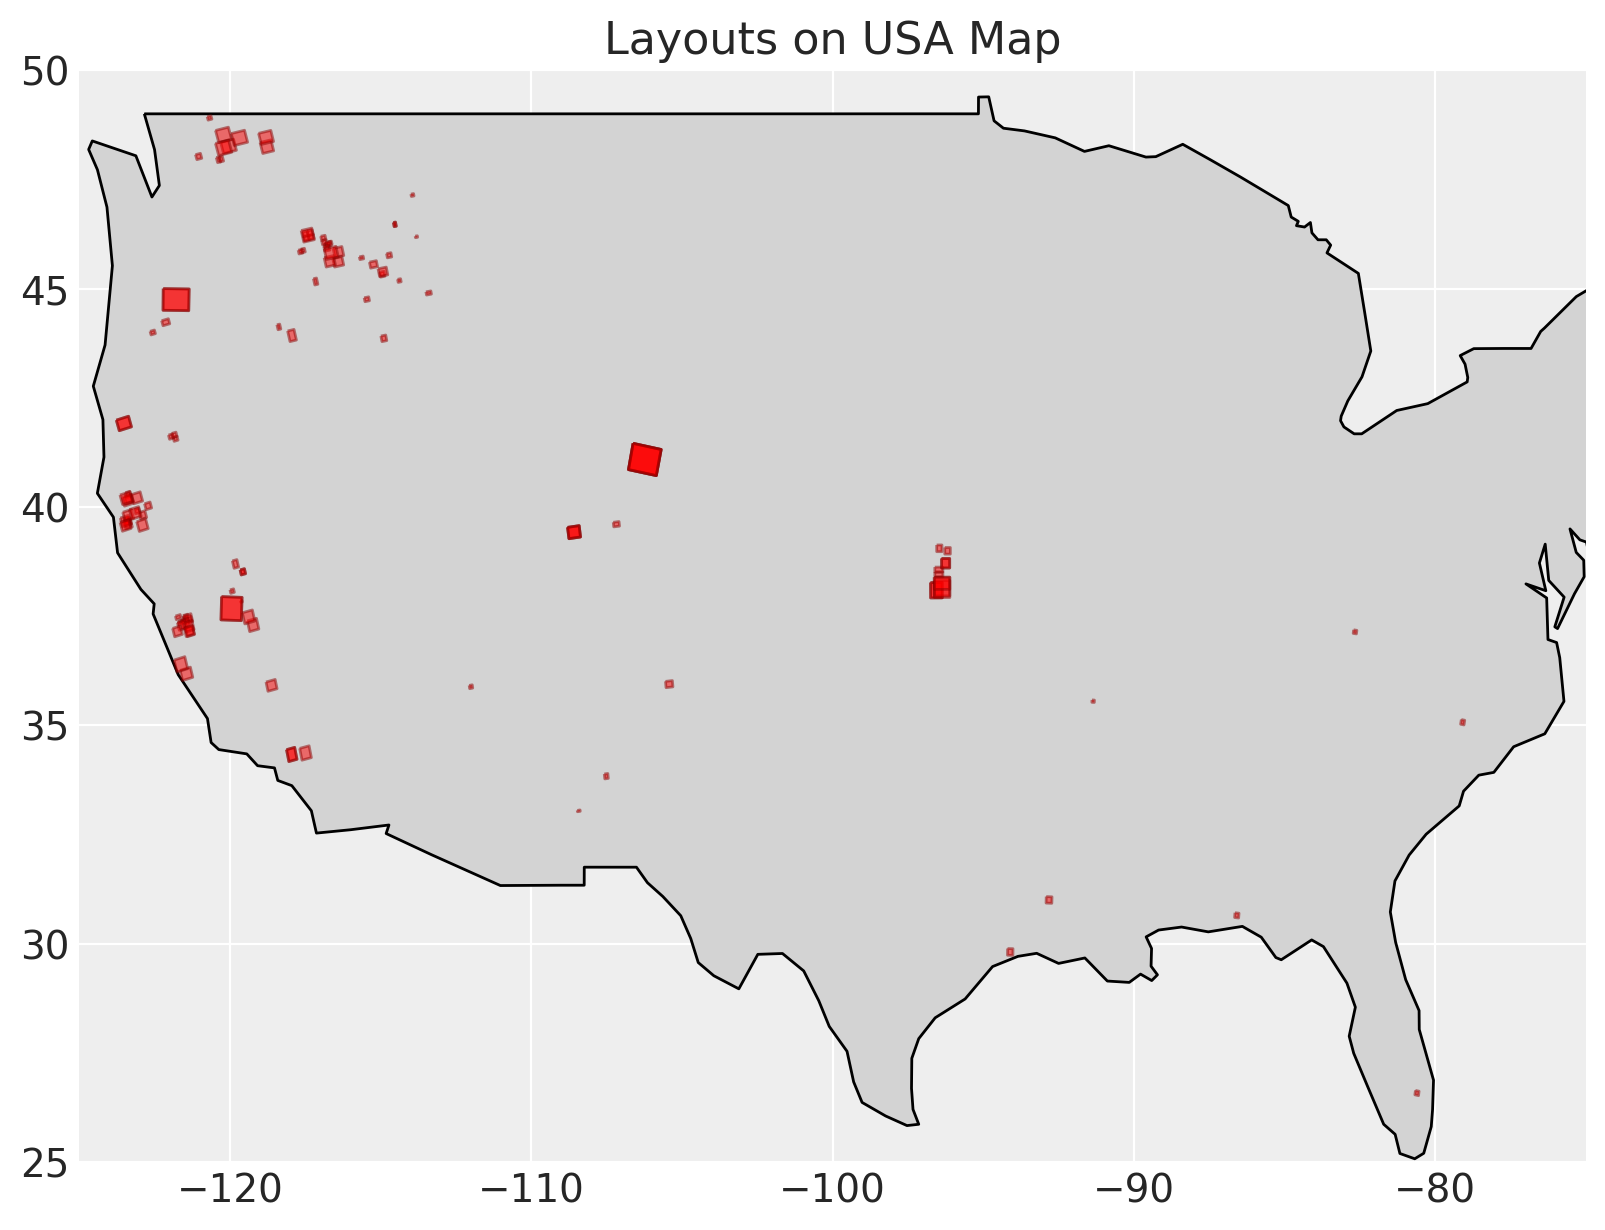

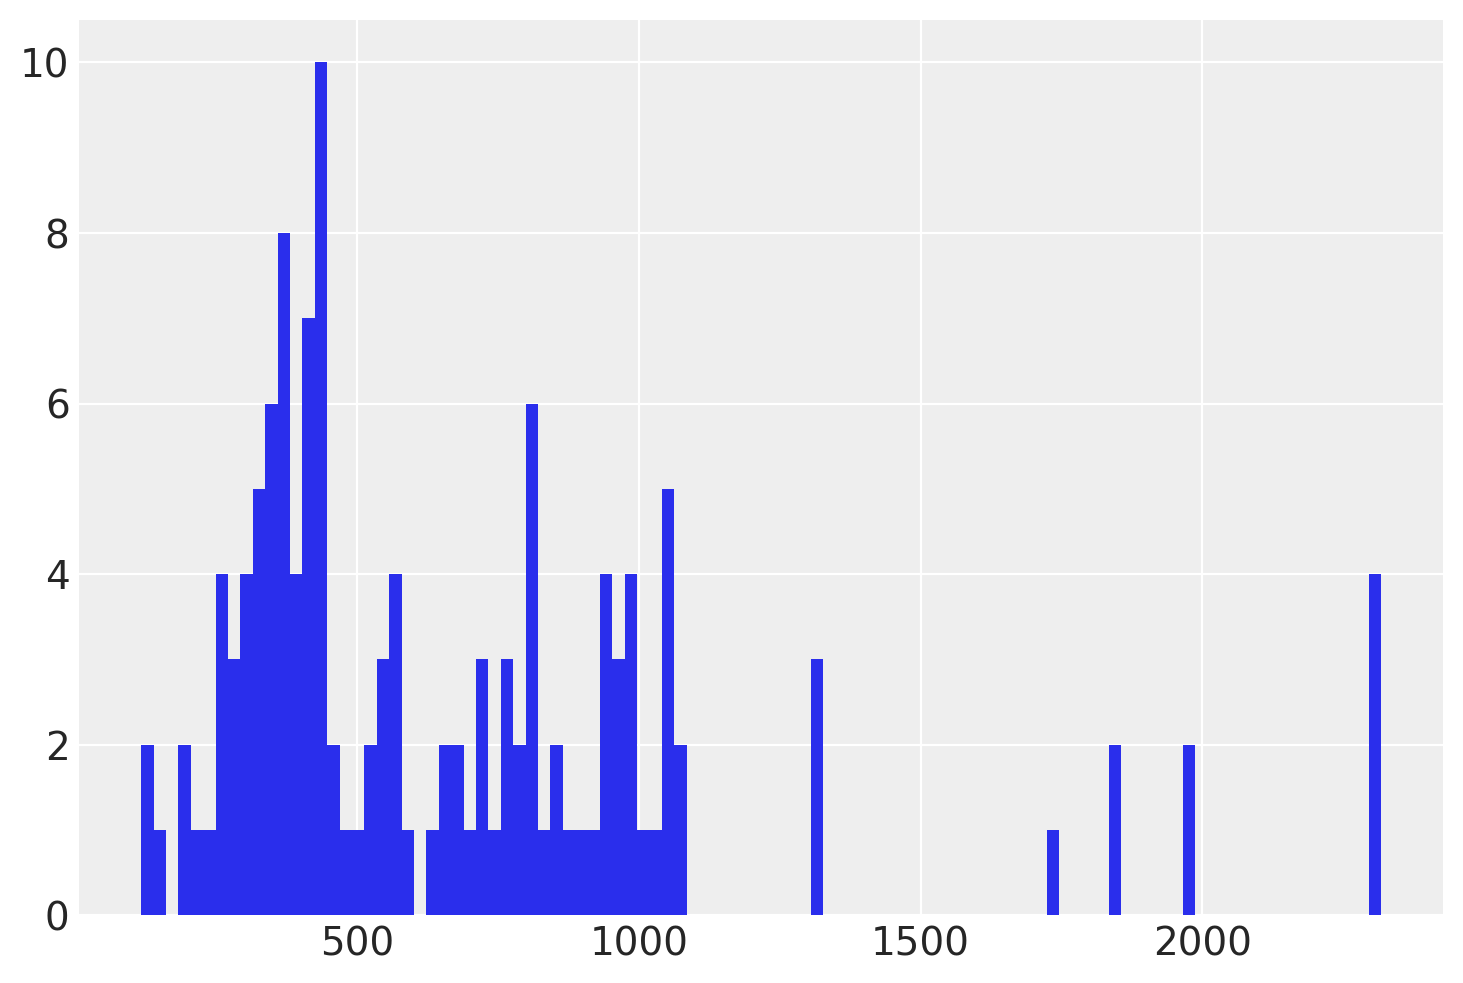

ValueError: Unknown column geometry

In [90]:
gdf = gpd.GeoDataFrame(layout_list, geometry='geometry', crs="EPSG:4326")
# print the shapes on the map
gdf.plot()
plt.show()

gdf = gpd.GeoDataFrame(layout_list, geometry='geometry', crs="EPSG:4326")

world = gpd.read_file("naturalearth_lowres/naturalearth_lowres.shp")
usa = world[world.name == 'United States of America']

# Step 3: Plot
fig, ax = plt.subplots(figsize=(10, 8))
usa.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color='red', alpha=0.5, edgecolor='darkred')

# set axis limits
ax.set_xlim(-125, -75)
ax.set_ylim(25, 50)

ax.set_title("Layouts on USA Map")
plt.tight_layout()
plt.show()


gdf = gpd.GeoDataFrame(filtered_layout_list, geometry='geometry', crs="EPSG:4326")
# print the shapes on the map
gdf.plot()
plt.show()

gdf = gpd.GeoDataFrame(filtered_layout_list, geometry='geometry', crs="EPSG:4326")

world = gpd.read_file("naturalearth_lowres/naturalearth_lowres.shp")
usa = world[world.name == 'United States of America']

# Step 3: Plot
fig, ax = plt.subplots(figsize=(10, 8))
usa.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color='red', alpha=0.5, edgecolor='darkred')

# set axis limits
ax.set_xlim(-125, -75)
ax.set_ylim(25, 50)

ax.set_title("Layouts on USA Map")
plt.tight_layout()
plt.show()

# print histogram of polygon widths
plt.hist(heights, bins=100)
plt.show()

# small layouts
small_layouts_gdf = gpd.GeoDataFrame(small_layouts, geometry='geometry', crs="EPSG:4326")
small_layouts_gdf.plot()
plt.show()

# medium layouts
medium_layouts_gdf = gpd.GeoDataFrame(medium_layouts, geometry='geometry', crs="EPSG:4326")
medium_layouts_gdf.plot()
plt.show()

# large layouts
large_layouts_gdf = gpd.GeoDataFrame(large_layouts, geometry='geometry', crs="EPSG:4326")
large_layouts_gdf.plot()
plt.show()














# FPA-FOD – Fire Program Analysis Fire Occurrence Database (USA)

What it has: 2+ million ignition points from 1992 to present (US), with cause, size, discovery time

Use for risk: Target variable (ignition), feature engineering (cause), spatiotemporal patterns

Link: https://www.fs.usda.gov/rds/archive/Catalog/RDS-2013-0009.5

In [60]:
fires_gdf = gpd.read_file("FPA_FOD_20210617.gpkg")

/opt/anaconda3/envs/wildfire/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'FPA_FOD_20210617.gpkg': 'Fires' (default), 'NWCG_UnitIdActive_20200123'. Specify layer parameter to avoid this warning.
  result = read_func(
/opt/anaconda3/envs/wildfire/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Non-conformant content for record 1 in column DISCOVERY_DATE, 2005-02-02T00:00:00.0Z, successfully parsed
  return ogr_read(


In [61]:
fires_gdf = fires_gdf.to_crs("EPSG:4326")

In [62]:
fires_gdf.DISCOVERY_DATE

0         2005-02-02 00:00:00+00:00
1         2004-05-12 00:00:00+00:00
2         2004-05-31 00:00:00+00:00
3         2004-06-28 00:00:00+00:00
4         2004-06-28 00:00:00+00:00
                     ...           
2166748   2016-10-18 00:00:00+00:00
2166749   2016-10-22 00:00:00+00:00
2166750   2017-04-02 00:00:00+00:00
2166751   2017-11-30 00:00:00+00:00
2166752   2015-07-20 00:00:00+00:00
Name: DISCOVERY_DATE, Length: 2166753, dtype: datetime64[ms, UTC]

## Spatial Join

In [63]:
# Spatial join: find which points fall into which polygons
joined = gpd.sjoin(fires_gdf, gdf, how='inner', predicate='within')
joined_small = gpd.sjoin(fires_gdf, small_layouts_gdf, how='inner', predicate='within')
joined_medium = gpd.sjoin(fires_gdf, medium_layouts_gdf, how='inner', predicate='within')
joined_large = gpd.sjoin(fires_gdf, large_layouts_gdf, how='inner', predicate='within')

# Count points per polygon
counts = joined.groupby('identifier').size().reset_index(name='fire_count')
counts_small = joined_small.groupby('identifier').size().reset_index(name='fire_count')
counts_medium = joined_medium.groupby('identifier').size().reset_index(name='fire_count')
counts_large = joined_large.groupby('identifier').size().reset_index(name='fire_count')


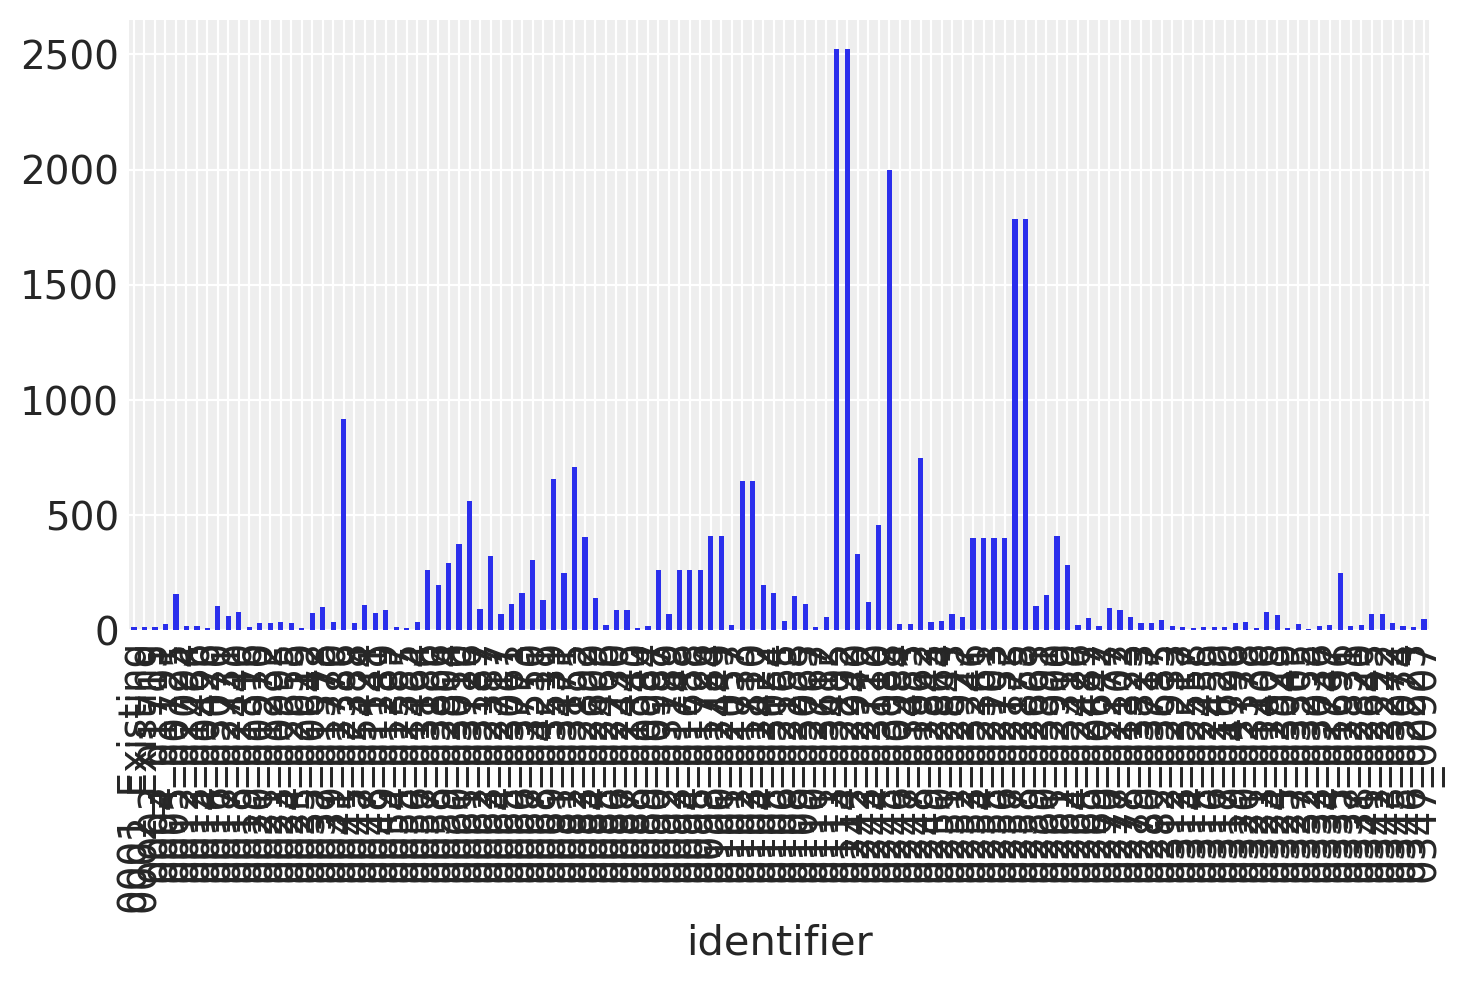

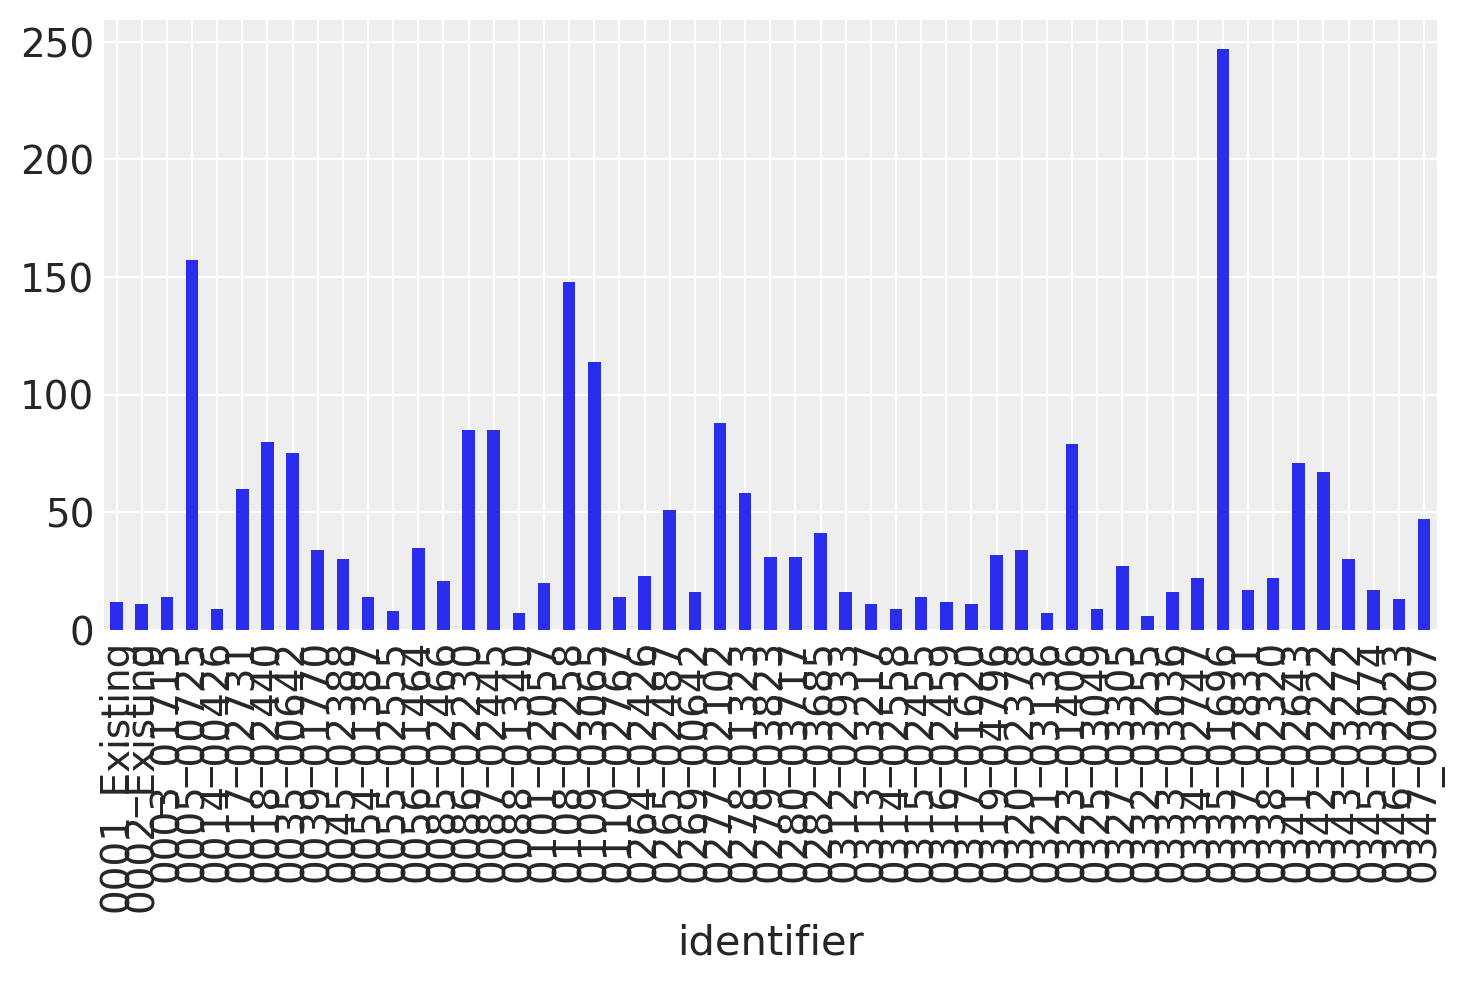

['0335_01696']


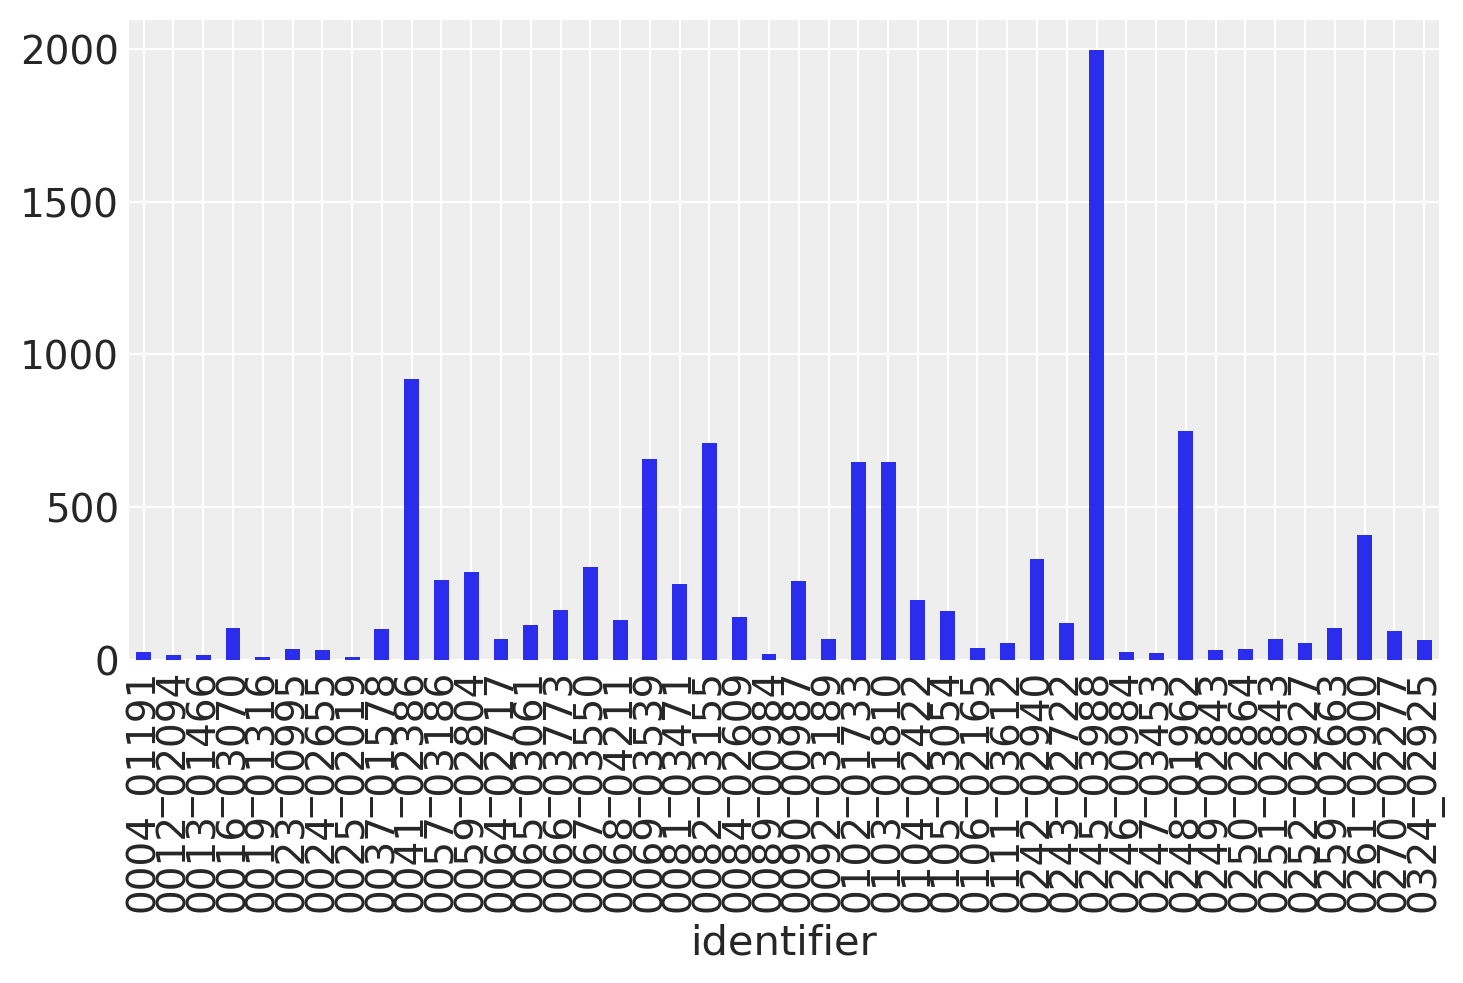

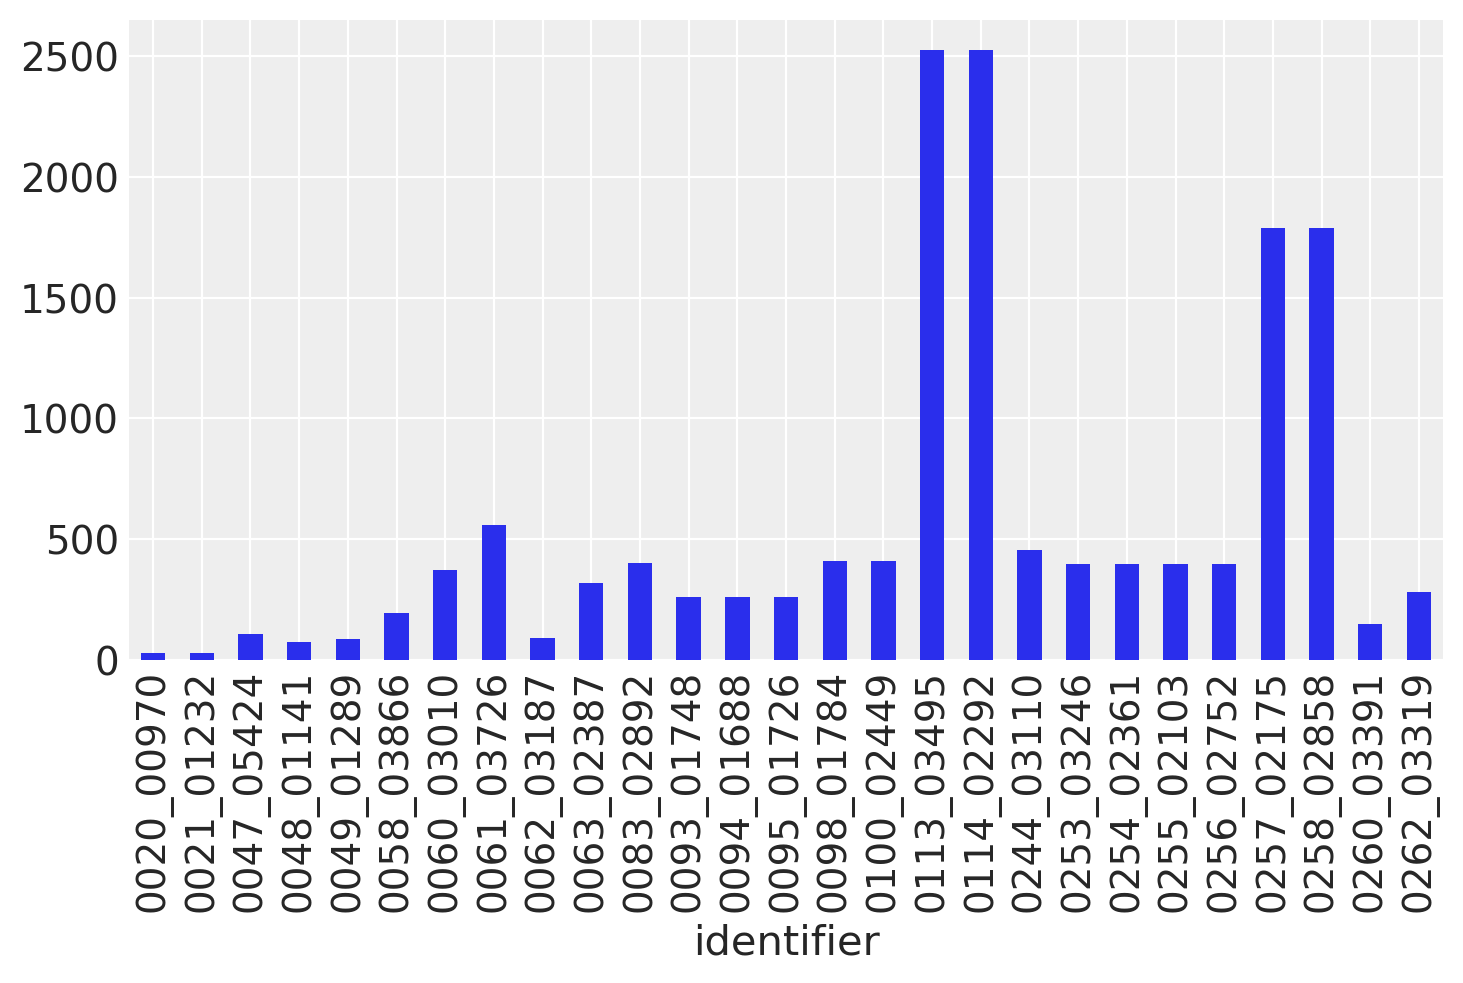

In [72]:
# plot counts per polygon as a bar plot
counts.plot(kind='bar', x='identifier', y='fire_count', legend=False)
plt.show()

# plot counts per polygon as a bar plot
counts_small.plot(kind='bar', x='identifier', y='fire_count', legend=False)
plt.show()
# print the identifier of the polygon with the most fires
max_fire_count_small = counts_small['fire_count'].max()
print(counts_small[counts_small['fire_count'] == max_fire_count_small]['identifier'].unique())

# plot counts per polygon as a bar plot
counts_medium.plot(kind='bar', x='identifier', y='fire_count', legend=False)
plt.show()

# plot counts per polygon as a bar plot
counts_large.plot(kind='bar', x='identifier', y='fire_count', legend=False)
plt.show()

# # print how many have fire_count > 100
# print(len(counts[counts['fire_count'] > 10]))

# # print names of the polygons with fire_count <10
# print(counts[counts['fire_count'] < 100]['identifier'].unique())




<Axes: xlabel='DISCOVERY_DATE'>

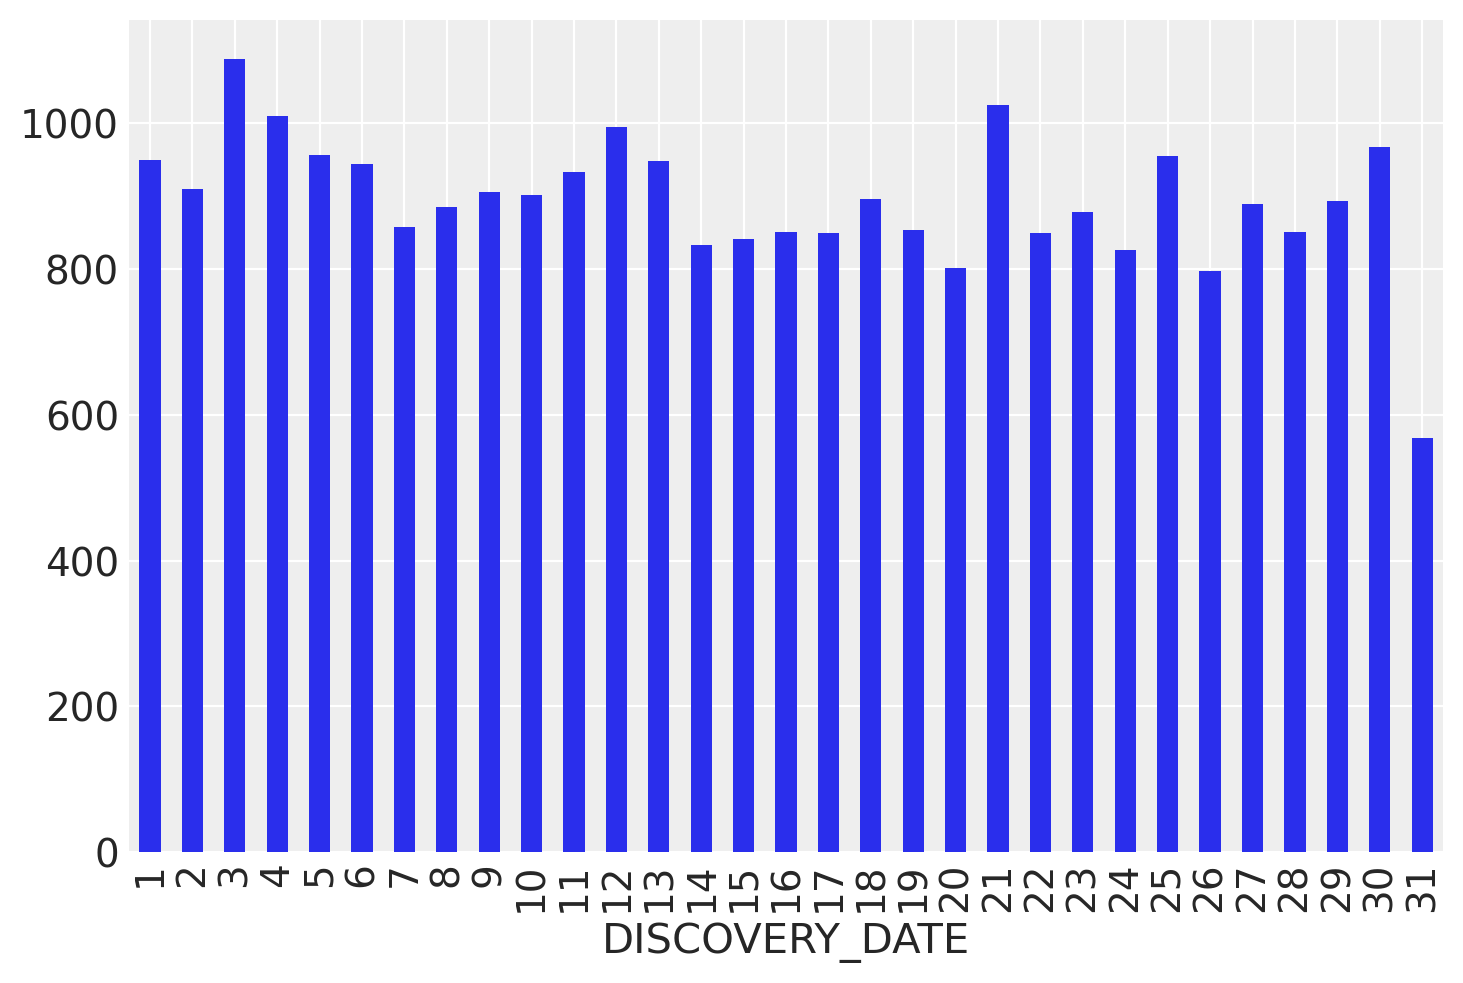

In [ ]:
joined.DISCOVERY_DATE.dt.day.value_counts().sort_index(ascending=True).plot(kind='bar')

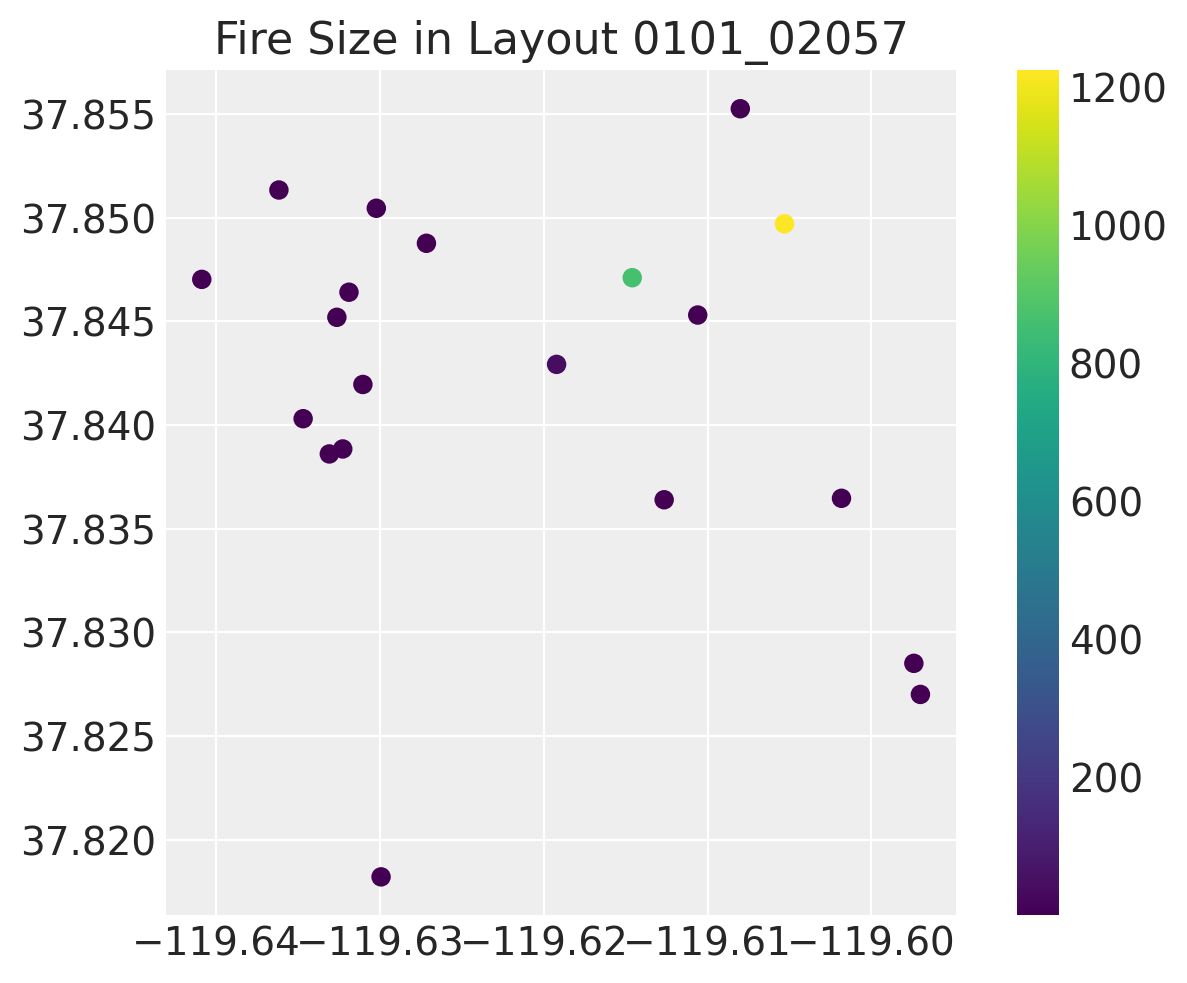

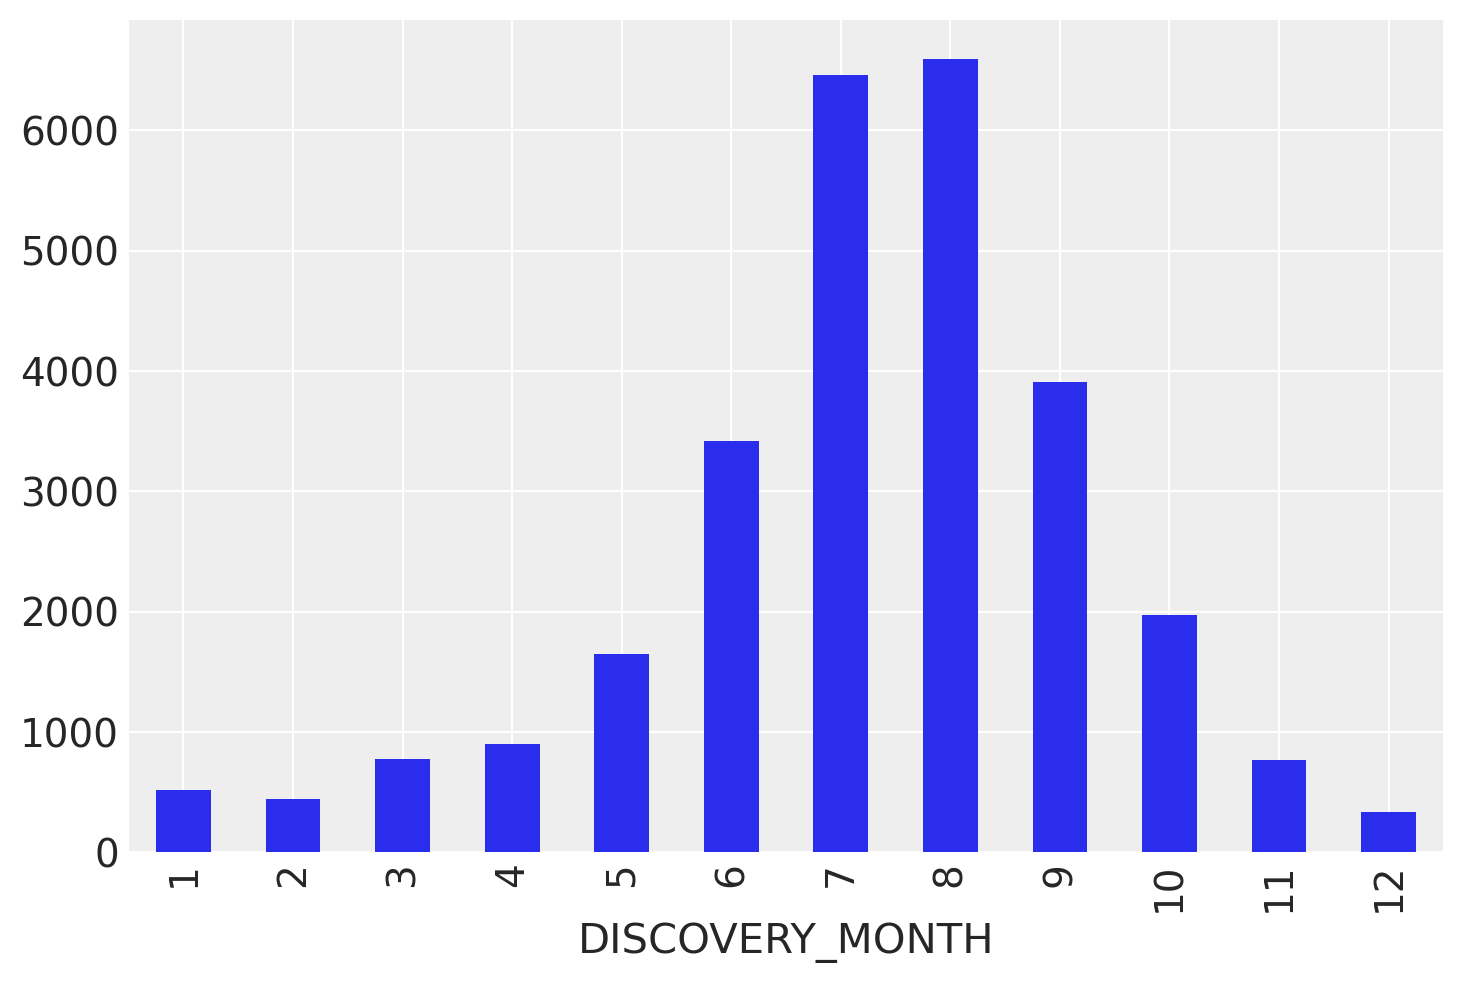

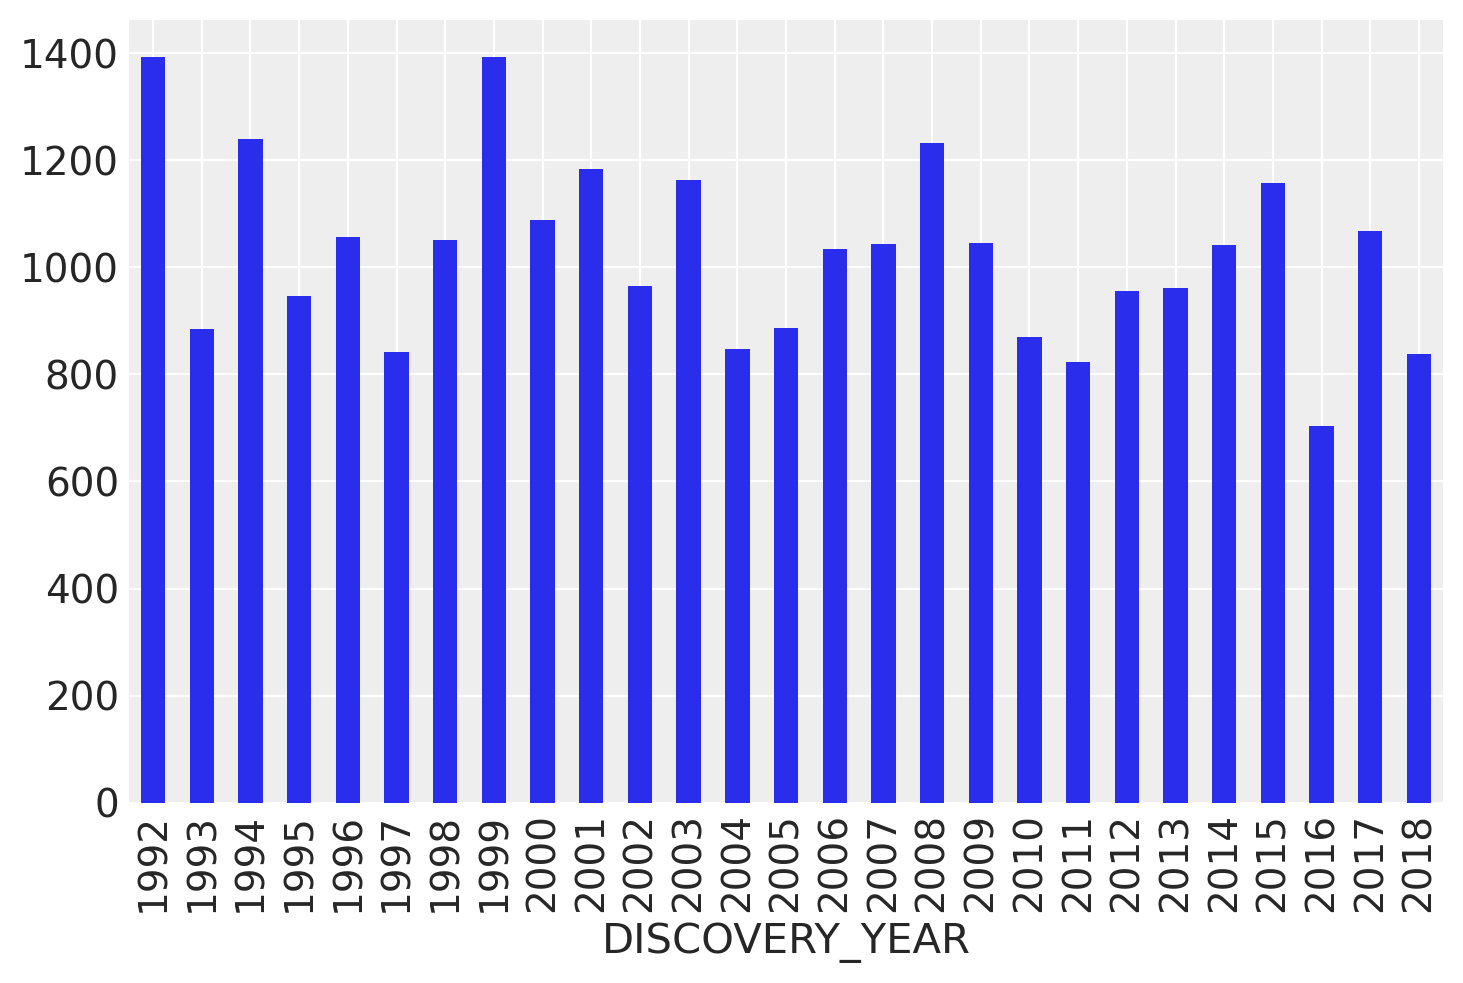

In [107]:
layout = '0101_02057'

joined[joined['identifier'] == layout].plot(column='FIRE_SIZE', cmap='viridis', legend=True)
plt.title(f'Fire Size in Layout {layout}')

plt.show()

# histogram plot of the discovery month (from the timestamp)
joined['DISCOVERY_MONTH'] = joined['DISCOVERY_DATE'].dt.month
joined['DISCOVERY_MONTH'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.show()

# plot the timeline of fire events in the layout as a histogram of the discovery year
joined['DISCOVERY_YEAR'] = joined['DISCOVERY_DATE'].dt.year
joined['DISCOVERY_YEAR'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.show()

# plot the timeline of fire events in the layout as a histogram of the discovery month and year



In [108]:
# Export one layout
joined[joined['identifier'] == layout][['LATITUDE','LONGITUDE','FIRE_SIZE']].to_csv(f"layout_{layout}_fire_data.csv", index=False)

# Log Gaussian Cox Process

In [109]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [110]:
data = pd.read_csv(f"layout_{layout}_fire_data.csv")
n = data.shape[0]

This dataset has coordinates and discrete mark values for each anemone. While these marks are integers, for the sake of simplicity we will model these values as continuous in a later step.

In [111]:
data.head(3)

,LATITUDE,LONGITUDE,FIRE_SIZE
0,37.83884,-119.63228,0.1
1,37.84702,-119.64089,0.1
2,37.83639,-119.61265,0.1


In [112]:
data.rename(
    columns={
        "LATITUDE": "y",
        "LONGITUDE": "x",
        "FIRE_SIZE": "marks",
    },
    inplace=True,
)

Let's take a look at this data in 2D space:

In [113]:
# # Shift coordinates so that min is 0
# data["x"] = data["x"] - data["x"].min()
# data["y"] = data["y"] - data["y"].min()

# data["x"] = data["x"] / data["x"].max() * 280
# data["y"] = data["y"] / data["y"].max() * 180

# Resulting (x, y) starts from 0
grid_coords = data[["x", "y"]].values

((-119.64626487561125, 37.85402542133113), (-119.60155440095348, 37.862849702826196), (-119.58945996245805, 37.82574698923346), (-119.63414940157975, 37.8169270635789), (-119.64626487561125, 37.85402542133113))
Latitude: 37° 49' 0.9374" N
Longitude: 119° 38' 46.5536" W
Latitude: 37° 51' 46.2589" N
Longitude: 119° 35' 22.0559" W
37.85402542133113
x_distance, y_distance 3832.3542041128967 6393.5776833649725


'\nLatitude, Longitude: 35.13454852501319, -79.13313349653575\nLatitude: 35° 8\' 4.3747" N\nLongitude: 79° 7\' 59.2806" W\nLatitude: 35° 1\' 28.0051" N\nLongitude: 79° 1\' 13.6322" W\n'

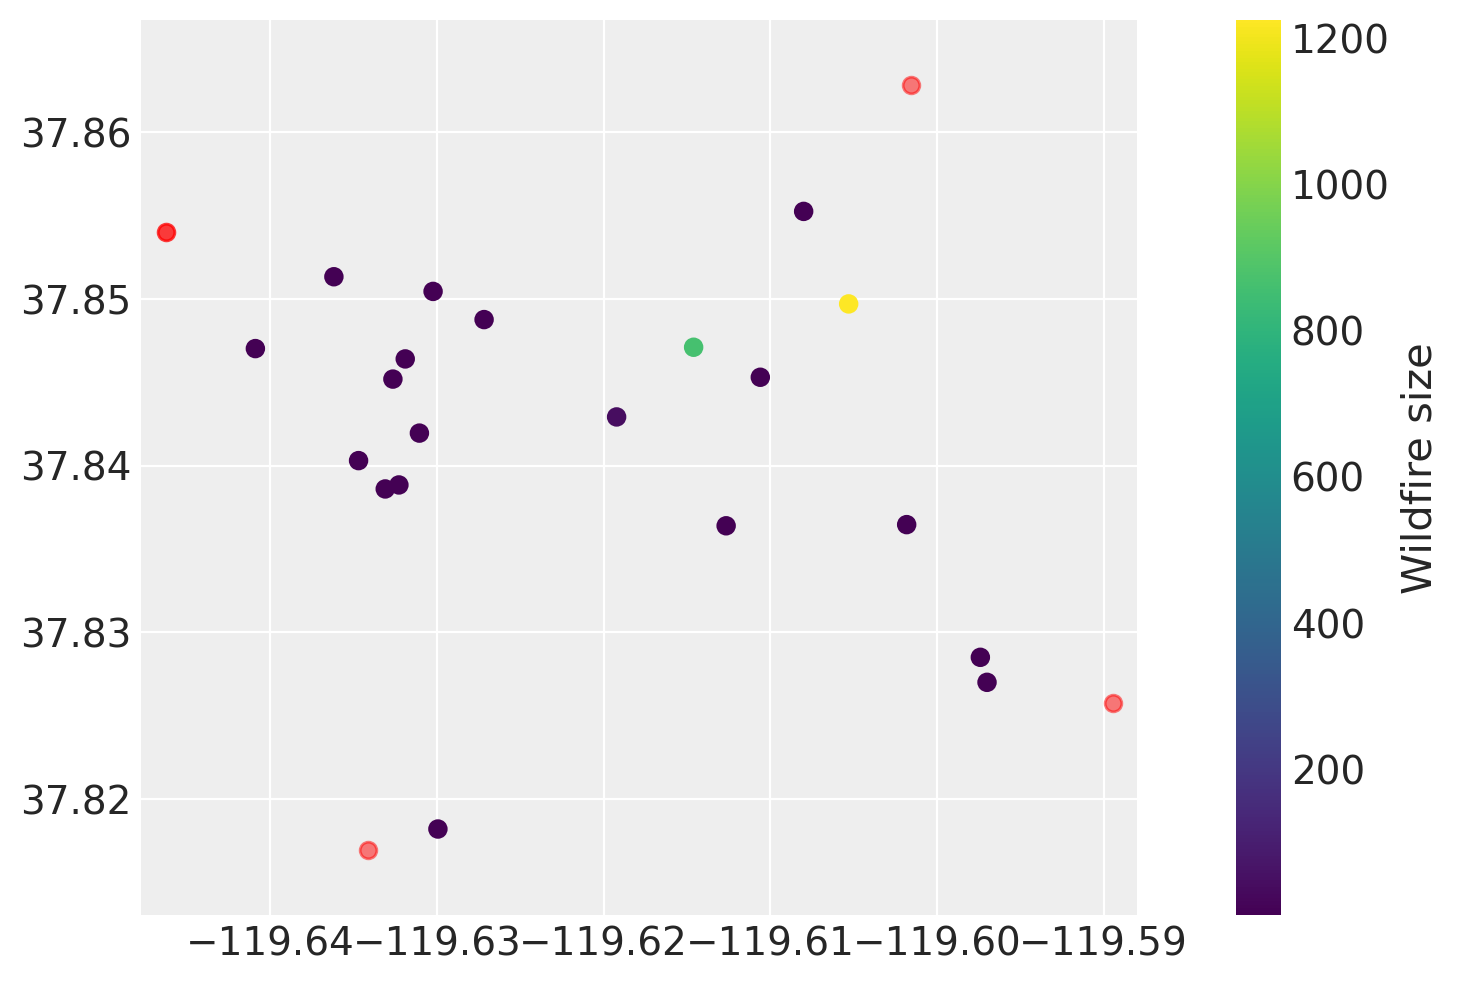

In [114]:
from shapely.geometry import Polygon, mapping, Point
layout_dict = {layout_name: layout_object for layout_name, layout_object in zip(names, filtered_layout_list)}

plt.scatter(data["x"], data["y"], c=data["marks"])
plt.colorbar(label="Wildfire size")
plt.axis("equal");
# plot boundaries of the layout
print(   mapping(layout_dict[layout]['geometry'])['coordinates'][0]    )

x_s = [ coord[0] for coord in mapping(layout_dict[layout]['geometry'])['coordinates'][0] ]
y_s = [ coord[1] for coord in mapping(layout_dict[layout]['geometry'])['coordinates'][0] ]

max_x = max(x_s)
min_x = min(x_s)
max_y = max(y_s)
min_y = min(y_s)

# prett print degree minutes seconds of the min and max x and y
lat_deg, lat_min, lat_sec = decimal_to_dms(min_y)
lon_deg, lon_min, lon_sec = decimal_to_dms(min_x)
print(f"Latitude: {abs(lat_deg)}° {lat_min}' {lat_sec:.4f}\" {'S' if lat_deg < 0 else 'N'}")
print(f"Longitude: {abs(lon_deg)}° {lon_min}' {lon_sec:.4f}\" {'W' if lon_deg < 0 else 'E'}")

lat_deg, lat_min, lat_sec = decimal_to_dms(max_y)
lon_deg, lon_min, lon_sec = decimal_to_dms(max_x)
print(f"Latitude: {abs(lat_deg)}° {lat_min}' {lat_sec:.4f}\" {'S' if lat_deg < 0 else 'N'}")
print(f"Longitude: {abs(lon_deg)}° {lon_min}' {lon_sec:.4f}\" {'W' if lon_deg < 0 else 'E'}")




def get_utm_zone(longitude):
    return int((longitude + 180) / 6) + 1


plt.scatter(x_s, y_s, c='red', alpha=0.5)
plt.axis("equal");


# project the coordinates to crs for distance calculation
points = [Point(x, y) for x, y in zip(x_s, y_s)]
gdf1 = gpd.GeoDataFrame(index=[0], geometry=[Point(min(x_s), min(y_s))], crs="EPSG:4326")
gdf2 = gpd.GeoDataFrame(index=[0], geometry=[Point(max(x_s), max(y_s))], crs="EPSG:4326")

# Determine the UTM zone
utm_zone = get_utm_zone(y_s[0])
print(y_s[0])

# Reproject to the corresponding UTM zone
gdf1 = gdf1.to_crs(epsg=32600 + utm_zone)
gdf2 = gdf2.to_crs(epsg=32600 + utm_zone)

x_distance = abs(gdf1.geometry.x[0] - gdf2.geometry.x[0])
y_distance = abs(gdf1.geometry.y[0] - gdf2.geometry.y[0])
print("x_distance, y_distance", x_distance, y_distance)



"""
Latitude, Longitude: 35.13454852501319, -79.13313349653575
Latitude: 35° 8' 4.3747" N
Longitude: 79° 7' 59.2806" W
Latitude: 35° 1' 28.0051" N
Longitude: 79° 1' 13.6322" W
"""


In [115]:
type(layout_dict[layout]['geometry'])

shapely.geometry.polygon.Polygon

The 'marks' column indicates the size of each anemone. If we were to model both the marks and the spatial distribution of points, we would be modeling a *marked Poisson point process*. Extending the basic point pattern model to include this feature is the second portion of this notebook.

While there are multiple ways to conduct inference, perhaps the  simplest way is to slice up our domain $X$ into many small pieces $A_1, A_2,...,A_M$ and fix the intensity field to be constant within each subset. Then, we will treat the number of points within each $A_j$ as a Poisson random variable such that $Y_j \sim Poisson(\lambda_j)$. and we also consider the $\log{\lambda_1}...,\log{\lambda_M}$ variables as a single draw from a Gaussian process.

The code below splits up the domain into grid cells, counts the number of points within each cell and also identifies its centroid.

          y          x  marks
0  37.83884 -119.63228    0.1
1  37.84702 -119.64089    0.1
2  37.83639 -119.61265    0.1
3  37.85045 -119.63023    0.1
4  37.85133 -119.63618    0.1
-119.64626487561125 [3.33660259e-04 6.58528470e-05] 37.85402542133113 [ 8.47235946e-05 -2.59429075e-04]
data min and max:
-119.64089 -119.597 37.8182 37.85525
bounding box:
-119.64626487561125 37.85402542133113 -119.58943892692197 37.82575134507397


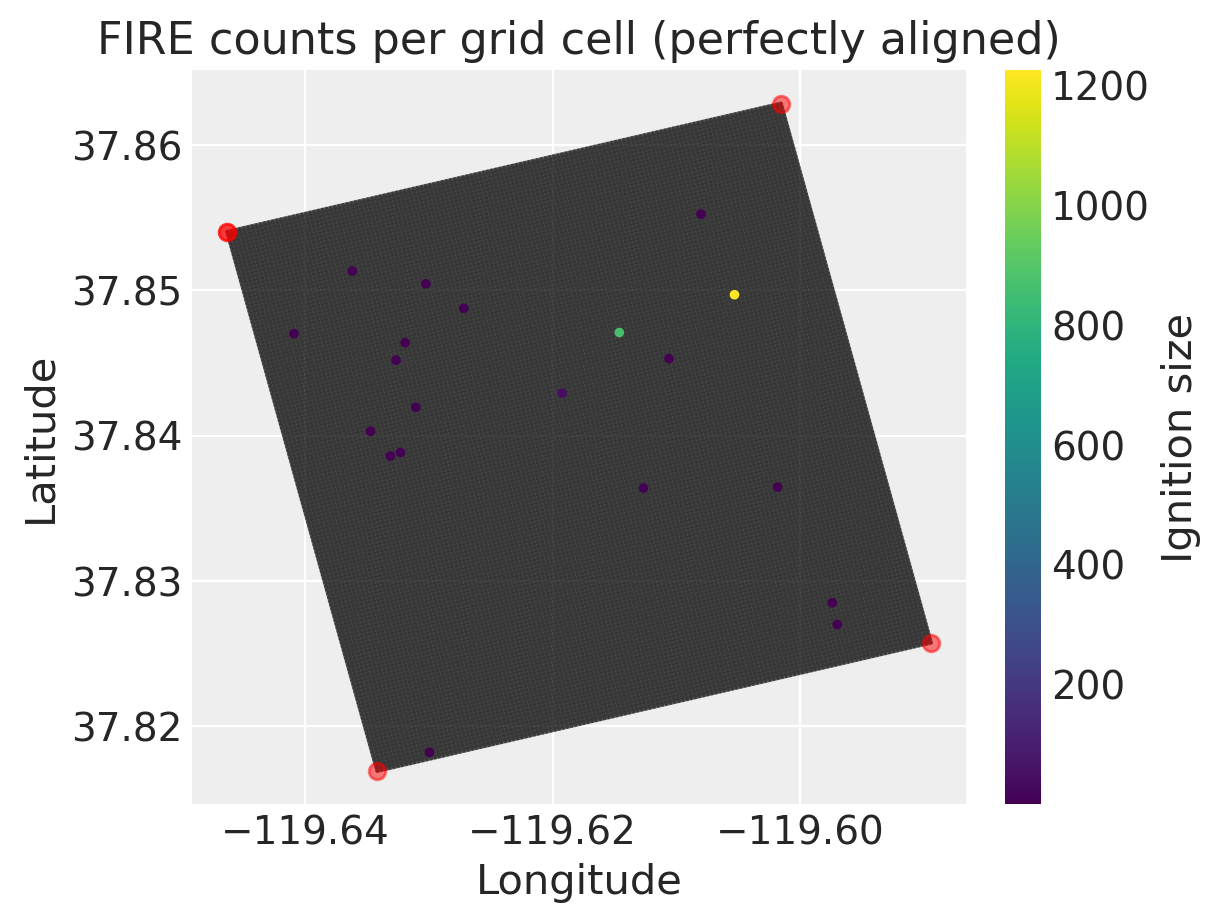

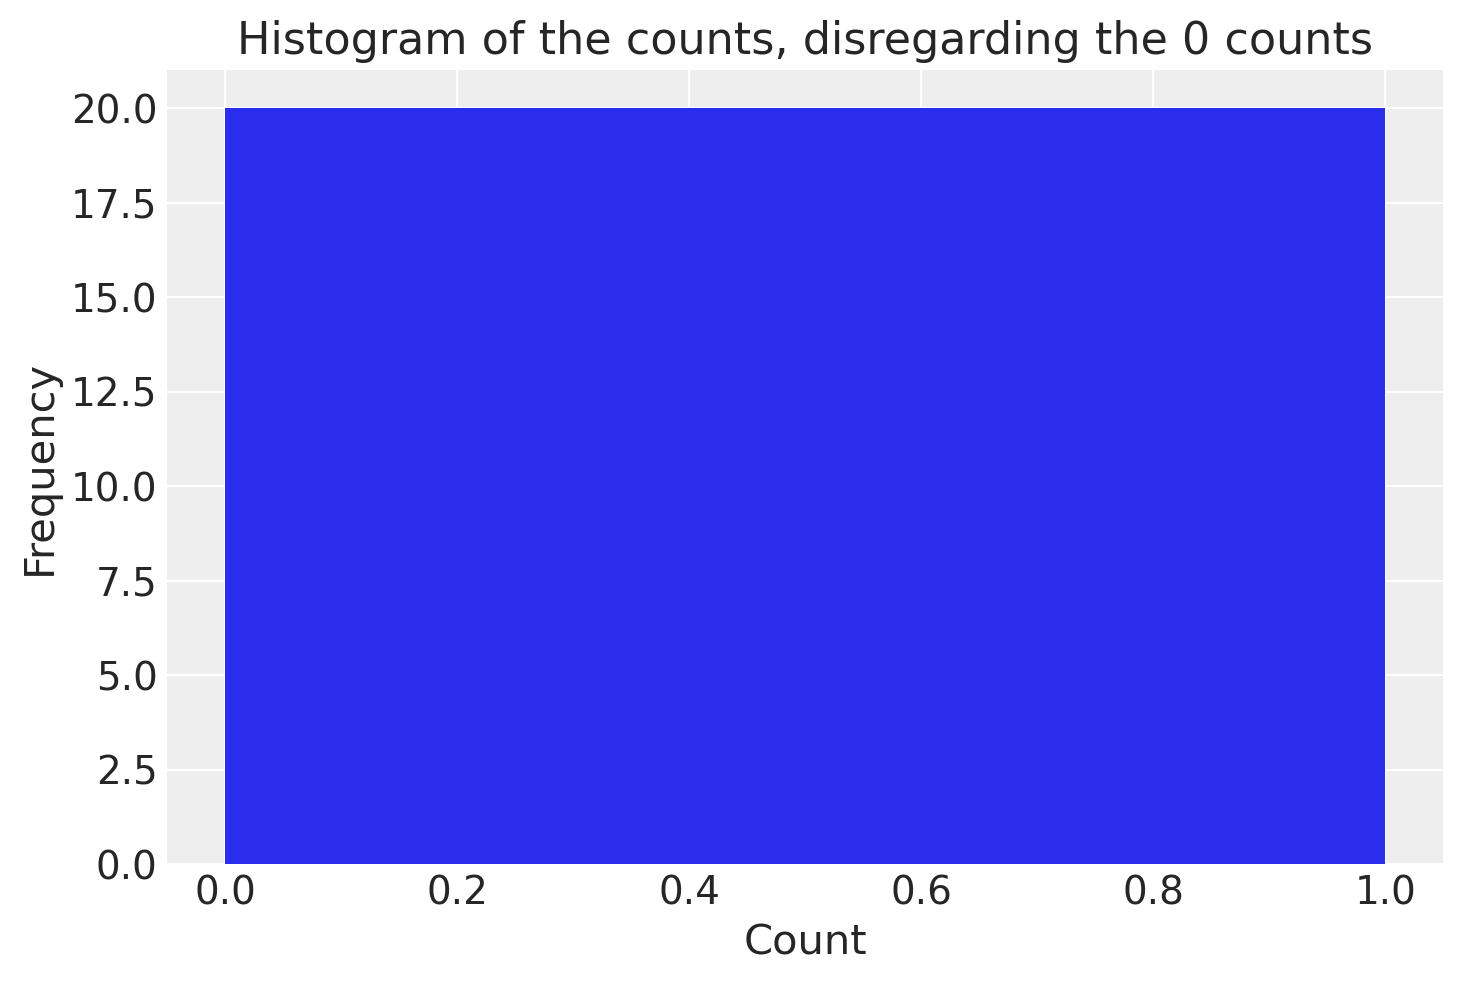

In [116]:
# open a scenario assoc to this layout

# import requred modules
import sys
import os

def return_first_scenario(path):
    chosen_subfolder = None
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_dir() and entry.name != '.DS_Store':
                chosen_subfolder = entry.name
                break
    if chosen_subfolder is None:
        raise ValueError("No subfolder found")
    return chosen_subfolder


# Add code to path
module_path = os.path.abspath(".") + "/code"
if module_path not in sys.path:
    sys.path.append(module_path)

from dataset import load_scenario

path = f"./WideDataset/{layout}/Satellite_Images_Mask/"

scenario = load_scenario(f"{path}{return_first_scenario(path)}", extension = ".jpg")

# asset width and heigh match with scenarios
assert layout_dict[layout]['width'] == scenario[0].shape[1], f"width does not match: {layout_dict[layout]['width']} != {scenario[0].shape[1]}"
assert layout_dict[layout]['height'] == scenario[0].shape[0], f"height does not match: {layout_dict[layout]['height']} != {scenario[0].shape[0]}"


# --- Parameters ---
cells_x = layout_dict[layout]['width'] / 1
cells_y = layout_dict[layout]['height'] / 1

assert round(cells_x) == cells_x, f"cells_x is not an integer: {cells_x}"
assert round(cells_y) == cells_y, f"cells_y is not an integer: {cells_y}"

cells_x = round(cells_x)
cells_y = round(cells_y)

# --- Define rectangle corners ---
P0 = np.array([x_s[0], y_s[0]])  # Reference corner
P1 = np.array([x_s[1], y_s[1]])  # Adjacent corner (defines one edge)
P3 = np.array([x_s[3], y_s[3]])  # Other adjacent corner

vec_u = (P1 - P0) / cells_x  # Step along one edge
vec_v = (P3 - P0) / cells_y  # Step along adjacent edge

# dot product of vec_u and vec_v: check it is a rectangle (so that all cells have the same area)
dot_product = np.dot(vec_u, vec_v)
assert dot_product <= 1e-4, "vec_u and vec_v are not perpendicular"

area_per_cell = np.linalg.norm(vec_u) * np.linalg.norm(vec_v)

# --- Plotting ---
plt.figure(figsize=(6, 4.5))

# Plot grid lines parallel to vec_v (vertical grid lines)
for i in range(cells_x + 1):
    start = P0 + i * vec_u
    end = start + cells_y * vec_v
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', alpha=0.5)

# Plot grid lines parallel to vec_u (horizontal grid lines)
for j in range(cells_y + 1):
    start = P0 + j * vec_v
    end = start + cells_x * vec_u
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', alpha=0.5)

# Plot boundary points
plt.scatter(x_s, y_s, c='red', alpha=0.5, zorder=3)

# compute cell counts
print(data.head())
print(P0[0], vec_u, P0[1], vec_v)
print("data min and max:")
print(data["x"].min(), data["x"].max(), data["y"].min(), data["y"].max())
print("bounding box:")
print(P0[0], P0[1], P0[0] + cells_x * vec_u[0] + cells_y * vec_v[0], P0[1] + cells_x * vec_u[1] + cells_y * vec_v[1])

import numpy as np
from collections import defaultdict

# --- Precompute inverse lattice matrix ---
M = np.column_stack((vec_u, vec_v))  # 2x2 matrix: [vec_u | vec_v]
M_inv = np.linalg.inv(M)  # Inverse matrix

# --- Initialize counts ---
cell_counts = np.zeros((cells_x, cells_y), dtype=int)

# --- Process all points efficiently ---
points = data[['x', 'y']].to_numpy()  # shape (N, 2)
relative_points = points - P0  # shift to origin

# Compute lattice coordinates [alpha, beta] for all points
lattice_coords = relative_points @ M_inv.T  # shape (N, 2)

# Floor to get integer cell indices (i, j)
i_indices = np.floor(lattice_coords[:, 0]).astype(int)
j_indices = np.floor(lattice_coords[:, 1]).astype(int)

# Filter points that fall within the grid bounds
valid_mask = (i_indices >= 0) & (i_indices < cells_x) & (j_indices >= 0) & (j_indices < cells_y)
valid_i = i_indices[valid_mask]
valid_j = j_indices[valid_mask]

# Count points per cell
for i, j in zip(valid_i, valid_j):
    cell_counts[i, j] += 1

# compute the centroids of the cells
centroids = np.array([[i * vec_u[0] + j * vec_v[0], i * vec_u[1] + j * vec_v[1]] for i in range(cells_x) for j in range(cells_y)])

# Optional: 
#cell_counts_flat = cell_counts.flatten()

# check that every point belongs to a cell
assert sum(cell_counts.flatten()) == len(data)

# Plot data points
plt.scatter(data["x"], data["y"], c=data["marks"], s=6, cmap='viridis', zorder=2)
plt.title("FIRE counts per grid cell (perfectly aligned)")
plt.colorbar(label="Ignition size")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show() 

# display histogram of the counts, disregarding the 0 counts
plt.hist(cell_counts[cell_counts > 0], bins=range(max(cell_counts[cell_counts > 0]) + 1))
plt.title("Histogram of the counts, disregarding the 0 counts")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()





In [117]:
!clang --version

Apple clang version 16.0.0 (clang-1600.0.26.6)
Target: arm64-apple-darwin24.3.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin


Total number of points: 20
Fraction of empty cells: 99.03%
Modeling 20 cells out of 2068 total cells
Reduction factor: 103.4x
setup done
counts done


Output()

Finished [100%]: Average Loss = 26.938


approx done
trace done
plottng results...
computing K...
K done
K_nn shape: (20, 20), K_nm shape: (20, 2068)
inverting the matrix...
solving done
1
2


RuntimeError: Colorbar layout of new layout engine not compatible with old engine, and a colorbar has been created.  Engine not changed.

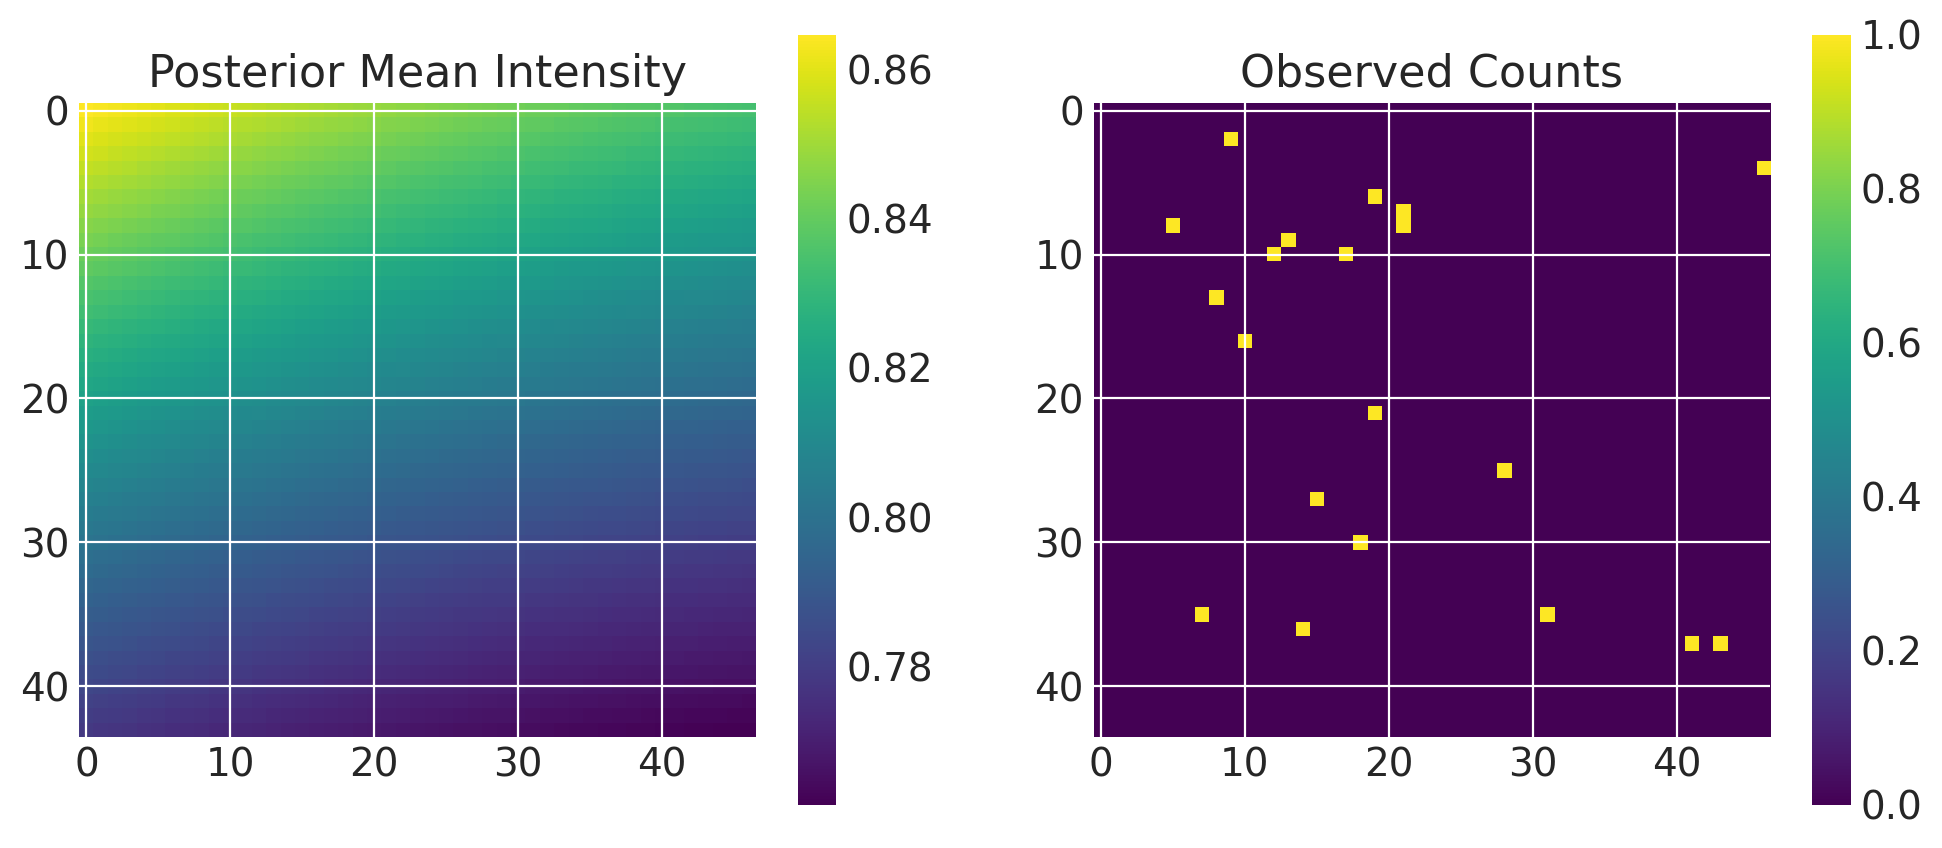

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
from scipy.spatial import distance_matrix
from scipy.ndimage import gaussian_filter
import pandas as pd

# --- Load wildfire data (replace with your actual data loading logic) ---
# Example: data = pd.read_csv('wildfire_data.csv')
# Columns: x, y, marks (optional)
# For demonstration, we assume 'data' is already loaded as a DataFrame

# --- Rectangle corners and grid setup (replace with your actual values) ---
# x_s, y_s: coordinates of the 4 corners of the rectangle (in order)
# layout_dict, layout, etc. should be defined as in your notebook
# For demonstration, we assume these are already defined

# --- Parameters ---
cells_x = layout_dict[layout]['width'] // 3
cells_y = layout_dict[layout]['height'] // 3

P0 = np.array([x_s[0], y_s[0]])  # Reference corner
P1 = np.array([x_s[1], y_s[1]])  # Adjacent corner (defines one edge)
P3 = np.array([x_s[3], y_s[3]])  # Other adjacent corner

vec_u = (P1 - P0) / cells_x  # Step along one edge
vec_v = (P3 - P0) / cells_y  # Step along adjacent edge

# --- Precompute inverse lattice matrix ---
M = np.column_stack((vec_u, vec_v))  # 2x2 matrix: [vec_u | vec_v]
M_inv = np.linalg.inv(M)  # Inverse matrix

# --- Initialize counts ---
cell_counts = np.zeros((cells_x, cells_y), dtype=int)

# --- Process all points efficiently ---
points = data[['x', 'y']].to_numpy()  # shape (N, 2)
relative_points = points - P0  # shift to origin
lattice_coords = relative_points @ M_inv.T  # shape (N, 2)
i_indices = np.floor(lattice_coords[:, 0]).astype(int)
j_indices = np.floor(lattice_coords[:, 1]).astype(int)
valid_mask = (i_indices >= 0) & (i_indices < cells_x) & (j_indices >= 0) & (j_indices < cells_y)
valid_i = i_indices[valid_mask]
valid_j = j_indices[valid_mask]
for i, j in zip(valid_i, valid_j):
    cell_counts[i, j] += 1

# --- Compute centroids of the cells ---
centroids = np.array([
    [P0 + i * vec_u + j * vec_v for j in range(cells_y)]
    for i in range(cells_x)
])
centroids_flat = centroids.reshape(-1, 2)
cell_counts_flat = cell_counts.flatten()

# --- LGCP Model ---
def rbf(X, X_, ls=1):
    X = X.reshape((-1,1)) if len(X.shape) == 1 else X
    X_ = X_.reshape((-1,1)) if len(X_.shape) == 1 else X_
    return np.exp(-(1/(2*ls)) * np.power(distance_matrix(X, X_), 2))

def fit_lgcp(cell_counts, grid_coords, ls_prior=2, variance_prior=10.0, threshold=0):
    nonzero_mask = cell_counts > threshold
    nonzero_counts = cell_counts[nonzero_mask]
    nonzero_coords = grid_coords[nonzero_mask]
    print(f"Modeling {len(nonzero_coords)} cells out of {len(grid_coords)} total cells")
    print(f"Reduction factor: {len(grid_coords)/len(nonzero_coords):.1f}x")
    with pm.Model() as lgcp_model:
        rho = pm.HalfNormal("rho", sigma=ls_prior, initval=1.0)
        variance = pm.HalfNormal("variance", sigma=variance_prior, initval=1.0)
        mu = pm.Normal("mu", 0.0, 3.0, initval=0.0)
        cov_func = variance * pm.gp.cov.ExpQuad(2, ls=rho)
        mean_func = pm.gp.mean.Constant(mu)
        gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
        log_intensity = gp.prior("log_intensity", X=nonzero_coords)
        intensity = pm.math.exp(log_intensity)
        area_per_cell = 1.0
        rates = intensity * area_per_cell
        print("setup done")
        counts = pm.Poisson("counts", mu=rates, observed=nonzero_counts)
        print("counts done")
        approx = pm.fit(n=10000, method='advi', 
                       obj_optimizer=pm.adam(learning_rate=0.01),
                       callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
        print("approx done")
        trace = approx.sample(1000)
        print("trace done")
    return trace, nonzero_mask

def predict_full_grid(trace, grid_coords, nonzero_mask, jitter=1e-6):
    rho = trace.posterior['rho'].mean().item()
    variance = trace.posterior['variance'].mean().item()
    mu = trace.posterior['mu'].mean().item()
    print("computing K...")
    K = rbf(grid_coords, grid_coords, ls=rho) * variance
    nonzero_log_intensity = trace.posterior['log_intensity'].mean(dim=['chain', 'draw']).values
    print("K done")
    K_nn = K[nonzero_mask][:, nonzero_mask]
    K_nm = K[nonzero_mask]
    K_nn += jitter * np.eye(K_nn.shape[0])
    print(f"K_nn shape: {K_nn.shape}, K_nm shape: {K_nm.shape}")
    print("inverting the matrix...")
    full_log_intensity = mu + K_nm.T @ np.linalg.solve(K_nn, nonzero_log_intensity - mu)
    print("solving done")
    full_intensity = np.exp(full_log_intensity)
    return full_intensity

# def predict_full_grid(trace, grid_coords, nonzero_mask, jitter=1e-6):
#     # Get the GP parameters from the trace
#     rho = trace.posterior['rho'].mean().item()
#     variance = trace.posterior['variance'].mean().item()
#     mu = trace.posterior['mu'].mean().item()

#     # Only use nonzero points for the GP fit
#     X_nonzero = grid_coords[nonzero_mask]
#     X_pred = grid_coords

#     # Compute only the necessary kernel blocks
#     K_nn = rbf(X_nonzero, X_nonzero, ls=rho) * variance
#     K_star_n = rbf(X_pred, X_nonzero, ls=rho) * variance

#     # Add jitter for numerical stability
#     K_nn += jitter * np.eye(K_nn.shape[0])

#     # GP prediction
#     nonzero_log_intensity = trace.posterior['log_intensity'].mean(dim=['chain', 'draw']).values
#     full_log_intensity = mu + K_star_n @ np.linalg.solve(K_nn, nonzero_log_intensity - mu)
#     full_intensity = np.exp(full_log_intensity)
#     return full_intensity

def plot_posterior_predictions(trace, grid_coords, cell_counts, true_intensity=None, nonzero_mask=None):
    if nonzero_mask is not None:
        post_pred = predict_full_grid(trace, grid_coords, nonzero_mask)
    else:
        post_pred = np.exp(trace.posterior['log_intensity'].mean(dim=['chain', 'draw']).values)
    print(1)
    grid_size_x = cells_x
    grid_size_y = cells_y
    post_pred_grid = post_pred.reshape(grid_size_x, grid_size_y)
    counts_grid = cell_counts.reshape(grid_size_x, grid_size_y)
    print(2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    im1 = ax1.imshow(post_pred_grid, cmap='viridis')
    ax1.set_title('Posterior Mean Intensity')
    plt.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(counts_grid, cmap='viridis')
    ax2.set_title('Observed Counts')
    plt.colorbar(im2, ax=ax2)
    plt.tight_layout()
    plt.show()

    if true_intensity is not None:
        true_intensity_grid = true_intensity.reshape(grid_size_x, grid_size_y)
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.imshow(true_intensity_grid, cmap='viridis')
        ax.set_title('True Intensity')
        plt.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()

# --- Run LGCP on wildfire data ---
if __name__ == "__main__":
    print(f"Total number of points: {cell_counts_flat.sum()}")
    print(f"Fraction of empty cells: {(cell_counts_flat == 0).mean():.2%}")
    trace, nonzero_mask = fit_lgcp(cell_counts_flat, centroids_flat, threshold=0)
    print("plottng results...")
    # After fitting the model
    #plot_random_patches(trace, centroids_flat, cell_counts_flat, nonzero_mask, patch_size=30, n_patches=3, grid_size_x=cells_x, grid_size_y=cells_y)
    plot_posterior_predictions(trace, centroids_flat, cell_counts_flat, nonzero_mask=nonzero_mask)
    print("\nParameter Estimates:")
    print(f"Length Scale: {trace.posterior['rho'].mean().item():.3f}")
    print(f"Variance: {trace.posterior['variance'].mean().item():.3f}")
    print(f"Mean: {trace.posterior['mu'].mean().item():.3f}") 

# Historical match: go go from historical ignition point to dataset ignition points

In [3]:


module_path = os.path.abspath(".") + "/code"
if module_path not in sys.path:
    sys.path.append(module_path)



from dataset import load_scenario
from scenario_sampler import ScenarioSampler

test_folder = "./WideDataset/0002/Satellite_Images_Mask/"
sampled_scenarios = []
# f"WideDataset/{folder}
sampler = ScenarioSampler(test_folder, extension = '.jpg')


# full pipeline:

# 0.1 preload all fires
# 0.2 preload all layouts

# for layout in layouts:
# 1. load a layout
# 2. identify fires within the layout
# 3. sample scenarios from historical fires, write them in a file
# 4. move these scenarios to a "selected_scenarios" folder
# 5. train test split
# enjoy


NameError: name 'os' is not defined